In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import time
from thop import profile


In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])
#%% Label
data_waist = []
label_waist = []
subject_waist = []

for i in range(len(data)):
    if(data['Device'][i] == 'Waist'):
        a = data['Acc'][i]*0.000244
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a)) 
        data_waist.append(b) 
        subject_waist.append(data['SubjectID'][i])
        # Class: fall = 0 ,ADL = 1 
        if (data['ActivityID'][i] > 100): 
            label_waist.append(1)
        else:
            label_waist.append(0)

# Change list to array
data_waist = np.array(data_waist)            
label_waist = np.array(label_waist)
subject_waist = np.array(subject_waist)

# Downsampling 1/128
down_data = []
# (start:size:step)
down_data = data_waist[::1,::128,::1]           
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]   

# The signal of each second 
per_sec = 38/20
sec = 7

In [3]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 

np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [7]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters//32, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(2, self.nb_filters//32,(3,1))
        
        print('Conv1:{}'.format(self.conv1)) 
        print('pool:{}'.format(self.pool)) 
        print('Conv2:{}'.format(self.conv2)) 
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(2*4,2)  
        #self.fc2 = nn.Linear(8,4)
        #self.fc3 = nn.Linear(8, 4)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(2, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x      
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters//32, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(2, self.nb_filters//32,(3,1))
        
        print('Conv1:{}'.format(self.conv1)) 
        print('pool:{}'.format(self.pool)) 
        print('Conv2:{}'.format(self.conv2)) 
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(2*4,2)  
        #self.fc2 = nn.Linear(8,4)
        #self.fc3 = nn.Linear(8, 4)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(2, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x      
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we

In [8]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [9]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [10]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return teacher_student_train_preds, teacher_student_train_gt


Subject 1
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3756 s/epoch | train loss 0.4559
| epoch   1 | 0.3126 s/epoch | train loss 0.4061
| epoch   2 | 0.3226 s/epoch | train loss 0.3438
| epoch   3 | 0.4103 s/epoch | train loss 0.3275
| epoch   4 | 0.3750 s/epoch | train loss 0.3149
| epoch   5 | 0.3380 s/epoch | train loss 0.3043
| epoch   6 | 0.3445 s/epoch | train loss 0.2723
| epoch   7 | 0.3330 s/epoch | train loss 0.3040
| epoch   8 | 0.3302 s/epoch | train loss 0.2821
| epoch   9 | 0.3288 s/epoch | train loss 0.2876
| epoch  10 | 0.3610 s/epoch | train loss 0.2573
| epoch  11 | 0.3910 s/epoch | train loss 0.2449
| epoch  12 | 0.3877 s/epoch | train loss 0.2429
| epoch  13 | 0.3892 s/epoch | train loss 0.4311
| epoch  14 | 0.3920 s/epoch | train loss 0.3761
| epoch  15 | 0.3905 s/epoch | train loss 0.3952
| epoch

| epoch 163 | 0.3933 s/epoch | train loss 0.0799
| epoch 164 | 0.3908 s/epoch | train loss 0.0702
| epoch 165 | 0.3805 s/epoch | train loss 0.0796
| epoch 166 | 0.3833 s/epoch | train loss 0.0784
| epoch 167 | 0.3926 s/epoch | train loss 0.2293
| epoch 168 | 0.3939 s/epoch | train loss 0.1461
| epoch 169 | 0.3960 s/epoch | train loss 0.0993
| epoch 170 | 0.3941 s/epoch | train loss 0.0898
| epoch 171 | 0.3789 s/epoch | train loss 0.0921
| epoch 172 | 0.3954 s/epoch | train loss 0.1218
| epoch 173 | 0.3969 s/epoch | train loss 0.0821
| epoch 174 | 0.3846 s/epoch | train loss 0.0714
| epoch 175 | 0.3923 s/epoch | train loss 0.0688
| epoch 176 | 0.4068 s/epoch | train loss 0.0619
| epoch 177 | 0.4055 s/epoch | train loss 0.0656
| epoch 178 | 0.4156 s/epoch | train loss 0.0672
| epoch 179 | 0.4083 s/epoch | train loss 0.2842
| epoch 180 | 0.4083 s/epoch | train loss 0.2073
| epoch 181 | 0.3996 s/epoch | train loss 0.1701
| epoch 182 | 0.3988 s/epoch | train loss 0.1559
| epoch 183 | 0.4048

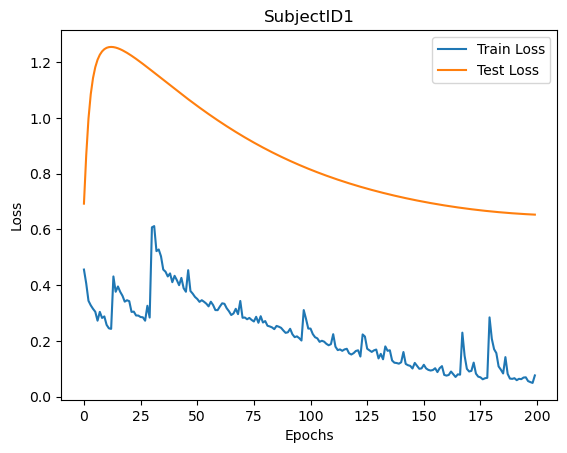

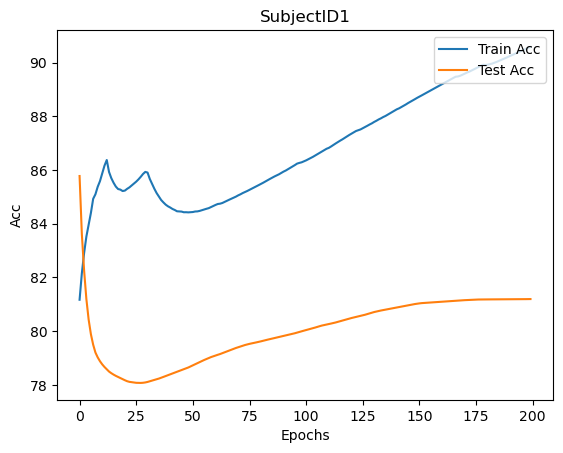

| epoch   0 | 0.0085 s/epoch | train loss 0.5406
| epoch   1 | 0.0074 s/epoch | train loss 0.5287
| epoch   2 | 0.0079 s/epoch | train loss 0.5263
| epoch   3 | 0.0077 s/epoch | train loss 0.5227
| epoch   4 | 0.0075 s/epoch | train loss 0.5223
| epoch   5 | 0.0078 s/epoch | train loss 0.5209
| epoch   6 | 0.0076 s/epoch | train loss 0.5221
| epoch   7 | 0.0061 s/epoch | train loss 0.5235
| epoch   8 | 0.0074 s/epoch | train loss 0.5235
| epoch   9 | 0.0069 s/epoch | train loss 0.5235
| epoch  10 | 0.0078 s/epoch | train loss 0.5235
| epoch  11 | 0.0069 s/epoch | train loss 0.5248
| epoch  12 | 0.0072 s/epoch | train loss 0.5248
| epoch  13 | 0.0075 s/epoch | train loss 0.5235
| epoch  14 | 0.0065 s/epoch | train loss 0.5222
| epoch  15 | 0.0077 s/epoch | train loss 0.5235
| epoch  16 | 0.0074 s/epoch | train loss 0.5261
| epoch  17 | 0.0073 s/epoch | train loss 0.5222
| epoch  18 | 0.0074 s/epoch | train loss 0.5235
| epoch  19 | 0.0077 s/epoch | train loss 0.5235
| epoch  20 | 0.0071

| epoch 168 | 0.0069 s/epoch | train loss 0.5222
| epoch 169 | 0.0073 s/epoch | train loss 0.5222
| epoch 170 | 0.0065 s/epoch | train loss 0.5248
| epoch 171 | 0.0069 s/epoch | train loss 0.5235
| epoch 172 | 0.0067 s/epoch | train loss 0.5235
| epoch 173 | 0.0068 s/epoch | train loss 0.5222
| epoch 174 | 0.0070 s/epoch | train loss 0.5288
| epoch 175 | 0.0072 s/epoch | train loss 0.5235
| epoch 176 | 0.0064 s/epoch | train loss 0.5235
| epoch 177 | 0.0072 s/epoch | train loss 0.5221
| epoch 178 | 0.0074 s/epoch | train loss 0.5208
| epoch 179 | 0.0071 s/epoch | train loss 0.5208
| epoch 180 | 0.0076 s/epoch | train loss 0.5208
| epoch 181 | 0.0066 s/epoch | train loss 0.5236
| epoch 182 | 0.0069 s/epoch | train loss 0.5248
| epoch 183 | 0.0069 s/epoch | train loss 0.5235
| epoch 184 | 0.0075 s/epoch | train loss 0.5221
| epoch 185 | 0.0067 s/epoch | train loss 0.5208
| epoch 186 | 0.0067 s/epoch | train loss 0.5221
| epoch 187 | 0.0071 s/epoch | train loss 0.5221
| epoch 188 | 0.0073

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


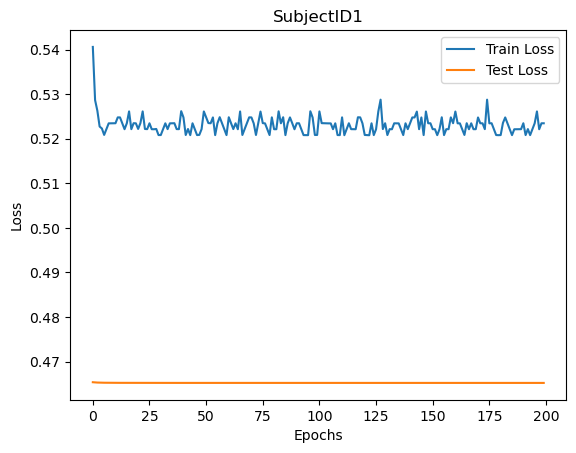

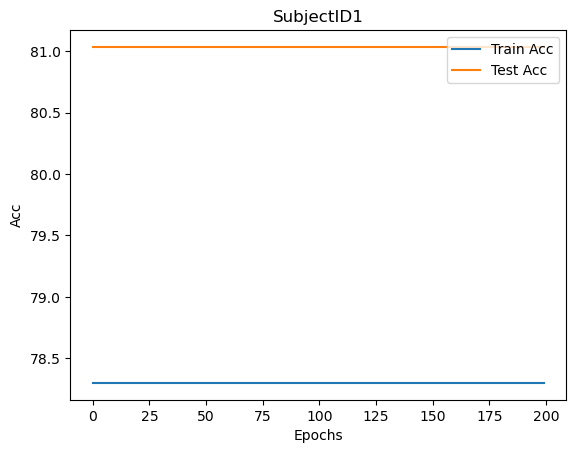


Subject 2
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3477 s/epoch | train loss 0.5296
| epoch   1 | 0.3549 s/epoch | train loss 0.4230
| epoch   2 | 0.3576 s/epoch | train loss 0.5307
| epoch   3 | 0.3498 s/epoch | train loss 0.4449
| epoch   4 | 0.3852 s/epoch | train loss 0.4432
| epoch   5 | 0.3829 s/epoch | train loss 0.4620
| epoch   6 | 0.3860 s/epoch | train loss 0.4313
| epoch   7 | 0.3717 s/epoch | train loss 0.4201
| epoch   8 | 0.3769 s/epoch | train loss 0.4387
| epoch   9 | 0.3734 s/epoch | train loss 0.3605
| epoch  10 | 0.3861 s/epoch | train loss 0.4734
| epoch  11 | 0.3877 s/epoch | train loss 0.4582
| epoch  12 | 0.3940 s/epoch | train loss 0.3966
| epoch  13 | 0.3873 s/epoch | train loss 0.3825
| epoch  14 | 0.3749 s/epoch | train loss 0.3818
| epoch  15 | 0.3741 s/epoch | train loss 0.4725
| epoch

| epoch 163 | 0.3350 s/epoch | train loss 0.3065
| epoch 164 | 0.3237 s/epoch | train loss 0.3065
| epoch 165 | 0.3218 s/epoch | train loss 0.2898
| epoch 166 | 0.3233 s/epoch | train loss 0.2800
| epoch 167 | 0.3212 s/epoch | train loss 0.2834
| epoch 168 | 0.3208 s/epoch | train loss 0.2736
| epoch 169 | 0.3224 s/epoch | train loss 0.2736
| epoch 170 | 0.3210 s/epoch | train loss 0.2573
| epoch 171 | 0.3208 s/epoch | train loss 0.2582
| epoch 172 | 0.3211 s/epoch | train loss 0.2528
| epoch 173 | 0.3222 s/epoch | train loss 0.2563
| epoch 174 | 0.3230 s/epoch | train loss 0.2586
| epoch 175 | 0.3223 s/epoch | train loss 0.2382
| epoch 176 | 0.3238 s/epoch | train loss 0.2809
| epoch 177 | 0.3199 s/epoch | train loss 0.2378
| epoch 178 | 0.3203 s/epoch | train loss 0.2224
| epoch 179 | 0.3212 s/epoch | train loss 0.2286
| epoch 180 | 0.3211 s/epoch | train loss 0.2325
| epoch 181 | 0.3218 s/epoch | train loss 0.2308
| epoch 182 | 0.3250 s/epoch | train loss 0.2437
| epoch 183 | 0.3212

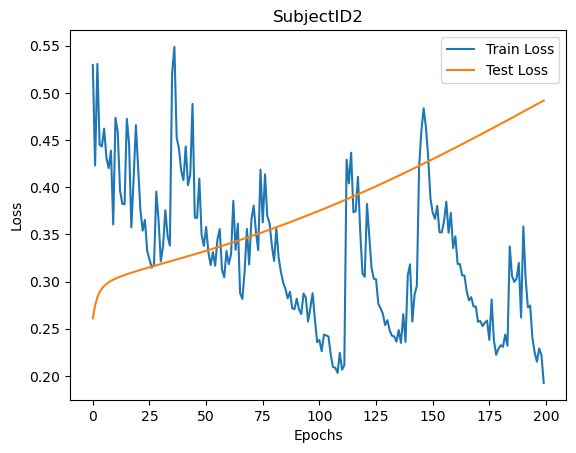

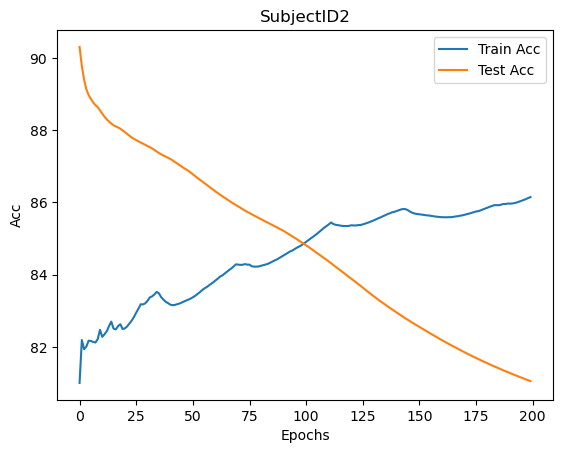

| epoch   0 | 0.0055 s/epoch | train loss 0.5313
| epoch   1 | 0.0056 s/epoch | train loss 0.5217
| epoch   2 | 0.0058 s/epoch | train loss 0.5233
| epoch   3 | 0.0057 s/epoch | train loss 0.5166
| epoch   4 | 0.0058 s/epoch | train loss 0.5159
| epoch   5 | 0.0058 s/epoch | train loss 0.5186
| epoch   6 | 0.0058 s/epoch | train loss 0.5215
| epoch   7 | 0.0058 s/epoch | train loss 0.5156
| epoch   8 | 0.0055 s/epoch | train loss 0.5156
| epoch   9 | 0.0059 s/epoch | train loss 0.5155
| epoch  10 | 0.0055 s/epoch | train loss 0.5155
| epoch  11 | 0.0059 s/epoch | train loss 0.5185
| epoch  12 | 0.0058 s/epoch | train loss 0.5155
| epoch  13 | 0.0057 s/epoch | train loss 0.5215
| epoch  14 | 0.0057 s/epoch | train loss 0.5215
| epoch  15 | 0.0058 s/epoch | train loss 0.5185
| epoch  16 | 0.0062 s/epoch | train loss 0.5156
| epoch  17 | 0.0055 s/epoch | train loss 0.5155
| epoch  18 | 0.0057 s/epoch | train loss 0.5155
| epoch  19 | 0.0060 s/epoch | train loss 0.5185
| epoch  20 | 0.0055

| epoch 168 | 0.0057 s/epoch | train loss 0.5157
| epoch 169 | 0.0062 s/epoch | train loss 0.5215
| epoch 170 | 0.0057 s/epoch | train loss 0.5185
| epoch 171 | 0.0060 s/epoch | train loss 0.5185
| epoch 172 | 0.0059 s/epoch | train loss 0.5215
| epoch 173 | 0.0058 s/epoch | train loss 0.5244
| epoch 174 | 0.0058 s/epoch | train loss 0.5185
| epoch 175 | 0.0058 s/epoch | train loss 0.5156
| epoch 176 | 0.0062 s/epoch | train loss 0.5185
| epoch 177 | 0.0060 s/epoch | train loss 0.5185
| epoch 178 | 0.0061 s/epoch | train loss 0.5155
| epoch 179 | 0.0065 s/epoch | train loss 0.5185
| epoch 180 | 0.0060 s/epoch | train loss 0.5185
| epoch 181 | 0.0064 s/epoch | train loss 0.5156
| epoch 182 | 0.0059 s/epoch | train loss 0.5185
| epoch 183 | 0.0060 s/epoch | train loss 0.5156
| epoch 184 | 0.0063 s/epoch | train loss 0.5245
| epoch 185 | 0.0058 s/epoch | train loss 0.5215
| epoch 186 | 0.0065 s/epoch | train loss 0.5215
| epoch 187 | 0.0062 s/epoch | train loss 0.5156
| epoch 188 | 0.0059

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


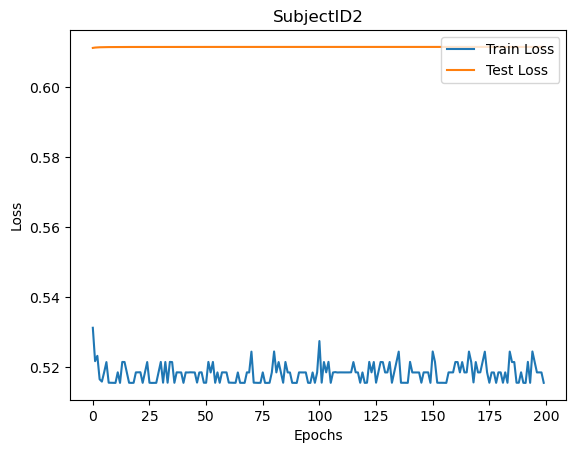

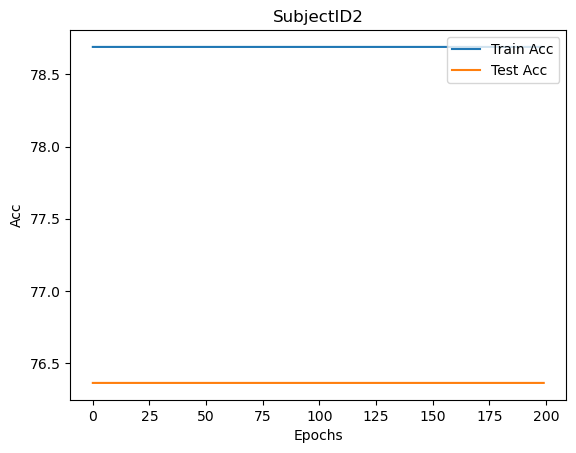


Subject 3
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3611 s/epoch | train loss 0.5133
| epoch   1 | 0.3555 s/epoch | train loss 0.4574
| epoch   2 | 0.3644 s/epoch | train loss 0.3258
| epoch   3 | 0.3569 s/epoch | train loss 0.2967
| epoch   4 | 0.3717 s/epoch | train loss 0.2814
| epoch   5 | 0.3663 s/epoch | train loss 0.2792
| epoch   6 | 0.3802 s/epoch | train loss 0.2607
| epoch   7 | 0.3869 s/epoch | train loss 0.2405
| epoch   8 | 0.3825 s/epoch | train loss 0.2345
| epoch   9 | 0.3903 s/epoch | train loss 0.2690
| epoch  10 | 0.3916 s/epoch | train loss 0.2307
| epoch  11 | 0.3790 s/epoch | train loss 0.2280
| epoch  12 | 0.3825 s/epoch | train loss 0.2214
| epoch  13 | 0.3888 s/epoch | train loss 0.2035
| epoch  14 | 0.3870 s/epoch | train loss 0.2053
| epoch  15 | 0.3760 s/epoch | train loss 0.2285
| epoch

| epoch 163 | 0.3852 s/epoch | train loss 0.0630
| epoch 164 | 0.3874 s/epoch | train loss 0.0665
| epoch 165 | 0.3763 s/epoch | train loss 0.0710
| epoch 166 | 0.3847 s/epoch | train loss 0.0664
| epoch 167 | 0.3799 s/epoch | train loss 0.0582
| epoch 168 | 0.3835 s/epoch | train loss 0.0595
| epoch 169 | 0.3886 s/epoch | train loss 0.1399
| epoch 170 | 0.3958 s/epoch | train loss 0.1669
| epoch 171 | 0.3921 s/epoch | train loss 0.0937
| epoch 172 | 0.3934 s/epoch | train loss 0.0742
| epoch 173 | 0.3886 s/epoch | train loss 0.0589
| epoch 174 | 0.3920 s/epoch | train loss 0.0532
| epoch 175 | 0.3891 s/epoch | train loss 0.0542
| epoch 176 | 0.3895 s/epoch | train loss 0.0570
| epoch 177 | 0.3931 s/epoch | train loss 0.0725
| epoch 178 | 0.3837 s/epoch | train loss 0.0518
| epoch 179 | 0.3800 s/epoch | train loss 0.0474
| epoch 180 | 0.3830 s/epoch | train loss 0.0660
| epoch 181 | 0.3856 s/epoch | train loss 0.0438
| epoch 182 | 0.3824 s/epoch | train loss 0.0651
| epoch 183 | 0.3852

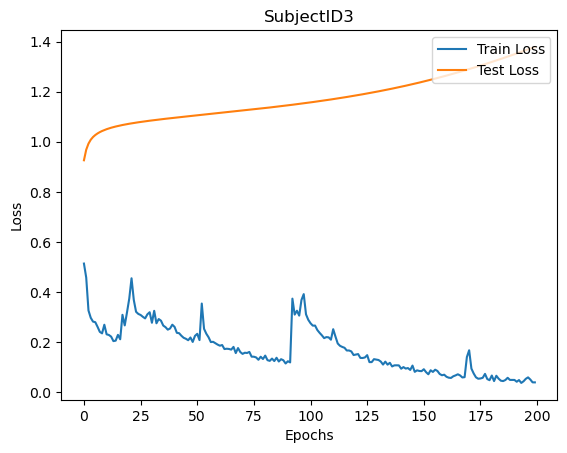

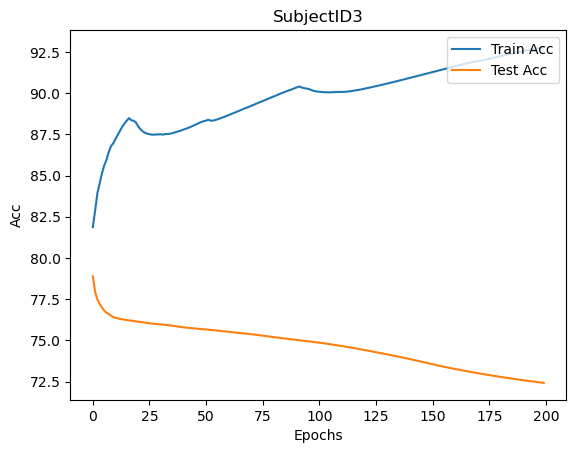

| epoch   0 | 0.0074 s/epoch | train loss 0.5084
| epoch   1 | 0.0082 s/epoch | train loss 0.4871
| epoch   2 | 0.0079 s/epoch | train loss 0.4549
| epoch   3 | 0.0076 s/epoch | train loss 0.4263
| epoch   4 | 0.0079 s/epoch | train loss 0.4139
| epoch   5 | 0.0075 s/epoch | train loss 0.4047
| epoch   6 | 0.0079 s/epoch | train loss 0.3986
| epoch   7 | 0.0075 s/epoch | train loss 0.3947
| epoch   8 | 0.0080 s/epoch | train loss 0.3924
| epoch   9 | 0.0077 s/epoch | train loss 0.3896
| epoch  10 | 0.0076 s/epoch | train loss 0.3886
| epoch  11 | 0.0077 s/epoch | train loss 0.3869
| epoch  12 | 0.0080 s/epoch | train loss 0.3861
| epoch  13 | 0.0082 s/epoch | train loss 0.3864
| epoch  14 | 0.0075 s/epoch | train loss 0.3843
| epoch  15 | 0.0082 s/epoch | train loss 0.3851
| epoch  16 | 0.0078 s/epoch | train loss 0.3834
| epoch  17 | 0.0073 s/epoch | train loss 0.3827
| epoch  18 | 0.0082 s/epoch | train loss 0.3841
| epoch  19 | 0.0082 s/epoch | train loss 0.3829
| epoch  20 | 0.0081

| epoch 168 | 0.0078 s/epoch | train loss 0.3593
| epoch 169 | 0.0077 s/epoch | train loss 0.3576
| epoch 170 | 0.0088 s/epoch | train loss 0.3591
| epoch 171 | 0.0079 s/epoch | train loss 0.3576
| epoch 172 | 0.0071 s/epoch | train loss 0.3572
| epoch 173 | 0.0080 s/epoch | train loss 0.3575
| epoch 174 | 0.0078 s/epoch | train loss 0.3590
| epoch 175 | 0.0075 s/epoch | train loss 0.3580
| epoch 176 | 0.0068 s/epoch | train loss 0.3576
| epoch 177 | 0.0076 s/epoch | train loss 0.3561
| epoch 178 | 0.0071 s/epoch | train loss 0.3585
| epoch 179 | 0.0074 s/epoch | train loss 0.3562
| epoch 180 | 0.0073 s/epoch | train loss 0.3574
| epoch 181 | 0.0079 s/epoch | train loss 0.3576
| epoch 182 | 0.0072 s/epoch | train loss 0.3579
| epoch 183 | 0.0071 s/epoch | train loss 0.3575
| epoch 184 | 0.0078 s/epoch | train loss 0.3582
| epoch 185 | 0.0080 s/epoch | train loss 0.3565
| epoch 186 | 0.0078 s/epoch | train loss 0.3577
| epoch 187 | 0.0074 s/epoch | train loss 0.3570
| epoch 188 | 0.0073

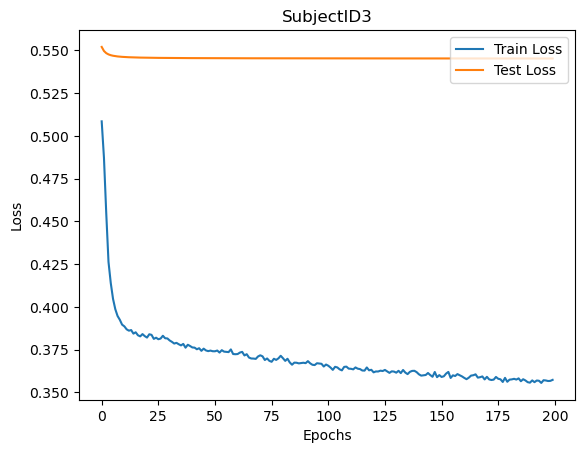

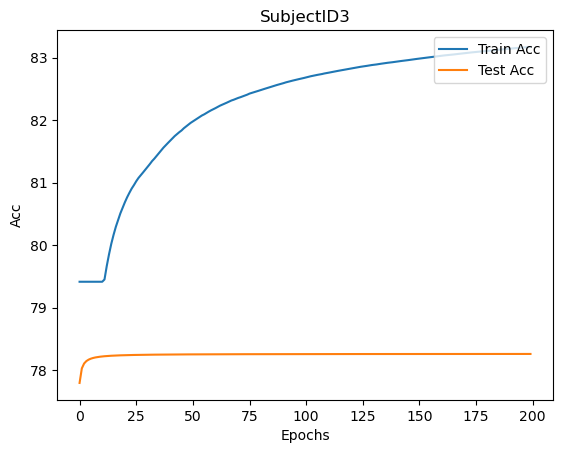


Subject 4
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.4720 s/epoch | train loss 0.4921
| epoch   1 | 0.4412 s/epoch | train loss 0.3975
| epoch   2 | 0.4208 s/epoch | train loss 0.3599
| epoch   3 | 0.3925 s/epoch | train loss 0.3986
| epoch   4 | 0.3919 s/epoch | train loss 0.3632
| epoch   5 | 0.3915 s/epoch | train loss 0.4545
| epoch   6 | 0.4338 s/epoch | train loss 0.4403
| epoch   7 | 0.4584 s/epoch | train loss 0.3579
| epoch   8 | 0.4382 s/epoch | train loss 0.3068
| epoch   9 | 0.4027 s/epoch | train loss 0.2815
| epoch  10 | 0.4122 s/epoch | train loss 0.3100
| epoch  11 | 0.4176 s/epoch | train loss 0.2981
| epoch  12 | 0.4128 s/epoch | train loss 0.2775
| epoch  13 | 0.4133 s/epoch | train loss 0.2692
| epoch  14 | 0.4125 s/epoch | train loss 0.2525
| epoch  15 | 0.4128 s/epoch | train loss 0.2479
| epoch

| epoch 163 | 0.4116 s/epoch | train loss 0.2109
| epoch 164 | 0.4062 s/epoch | train loss 0.2519
| epoch 165 | 0.4071 s/epoch | train loss 0.2346
| epoch 166 | 0.4122 s/epoch | train loss 0.2041
| epoch 167 | 0.3938 s/epoch | train loss 0.1876
| epoch 168 | 0.4063 s/epoch | train loss 0.1715
| epoch 169 | 0.4138 s/epoch | train loss 0.1693
| epoch 170 | 0.4152 s/epoch | train loss 0.1511
| epoch 171 | 0.4149 s/epoch | train loss 0.1604
| epoch 172 | 0.4142 s/epoch | train loss 0.1464
| epoch 173 | 0.3992 s/epoch | train loss 0.1466
| epoch 174 | 0.4024 s/epoch | train loss 0.1486
| epoch 175 | 0.4158 s/epoch | train loss 0.1446
| epoch 176 | 0.4218 s/epoch | train loss 0.1376
| epoch 177 | 0.4134 s/epoch | train loss 0.1303
| epoch 178 | 0.4024 s/epoch | train loss 0.1353
| epoch 179 | 0.3984 s/epoch | train loss 0.1308
| epoch 180 | 0.4085 s/epoch | train loss 0.1181
| epoch 181 | 0.4096 s/epoch | train loss 0.1205
| epoch 182 | 0.4095 s/epoch | train loss 0.1303
| epoch 183 | 0.4029

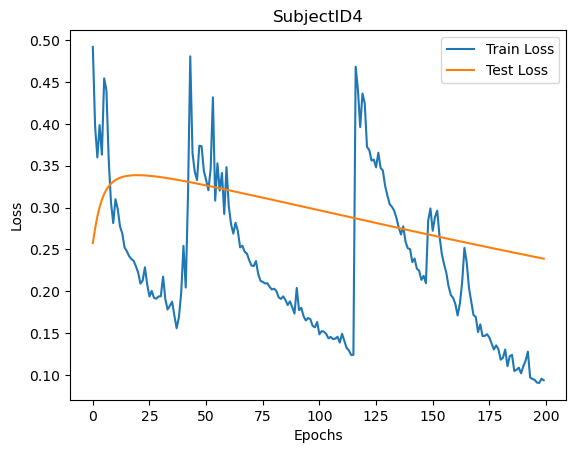

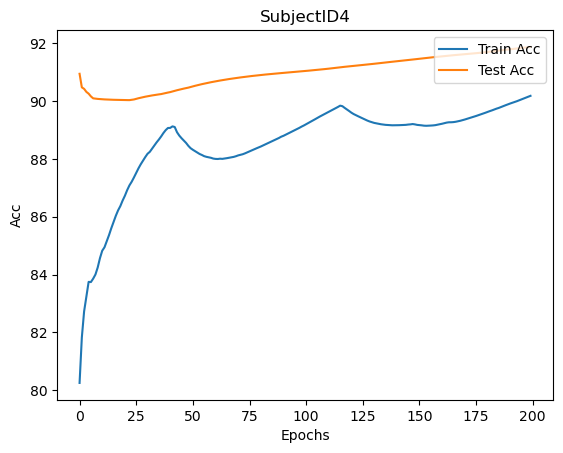

| epoch   0 | 0.0080 s/epoch | train loss 0.7844
| epoch   1 | 0.0076 s/epoch | train loss 0.6965
| epoch   2 | 0.0079 s/epoch | train loss 0.6123
| epoch   3 | 0.0077 s/epoch | train loss 0.5616
| epoch   4 | 0.0082 s/epoch | train loss 0.5411
| epoch   5 | 0.0078 s/epoch | train loss 0.5358
| epoch   6 | 0.0082 s/epoch | train loss 0.5337
| epoch   7 | 0.0078 s/epoch | train loss 0.5343
| epoch   8 | 0.0079 s/epoch | train loss 0.5355
| epoch   9 | 0.0076 s/epoch | train loss 0.5327
| epoch  10 | 0.0075 s/epoch | train loss 0.5339
| epoch  11 | 0.0078 s/epoch | train loss 0.5331
| epoch  12 | 0.0079 s/epoch | train loss 0.5339
| epoch  13 | 0.0075 s/epoch | train loss 0.5327
| epoch  14 | 0.0073 s/epoch | train loss 0.5343
| epoch  15 | 0.0075 s/epoch | train loss 0.5335
| epoch  16 | 0.0080 s/epoch | train loss 0.5347
| epoch  17 | 0.0081 s/epoch | train loss 0.5344
| epoch  18 | 0.0074 s/epoch | train loss 0.5340
| epoch  19 | 0.0081 s/epoch | train loss 0.5339
| epoch  20 | 0.0077

| epoch 168 | 0.0076 s/epoch | train loss 0.5340
| epoch 169 | 0.0075 s/epoch | train loss 0.5329
| epoch 170 | 0.0084 s/epoch | train loss 0.5343
| epoch 171 | 0.0077 s/epoch | train loss 0.5335
| epoch 172 | 0.0075 s/epoch | train loss 0.5343
| epoch 173 | 0.0075 s/epoch | train loss 0.5351
| epoch 174 | 0.0078 s/epoch | train loss 0.5340
| epoch 175 | 0.0078 s/epoch | train loss 0.5354
| epoch 176 | 0.0074 s/epoch | train loss 0.5336
| epoch 177 | 0.0079 s/epoch | train loss 0.5328
| epoch 178 | 0.0076 s/epoch | train loss 0.5339
| epoch 179 | 0.0088 s/epoch | train loss 0.5331
| epoch 180 | 0.0077 s/epoch | train loss 0.5343
| epoch 181 | 0.0079 s/epoch | train loss 0.5331
| epoch 182 | 0.0081 s/epoch | train loss 0.5339
| epoch 183 | 0.0080 s/epoch | train loss 0.5331
| epoch 184 | 0.0076 s/epoch | train loss 0.5336
| epoch 185 | 0.0080 s/epoch | train loss 0.5328
| epoch 186 | 0.0075 s/epoch | train loss 0.5340
| epoch 187 | 0.0083 s/epoch | train loss 0.5331
| epoch 188 | 0.0084

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


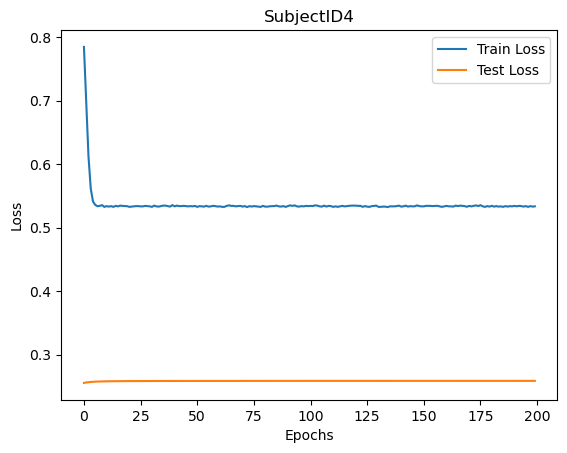

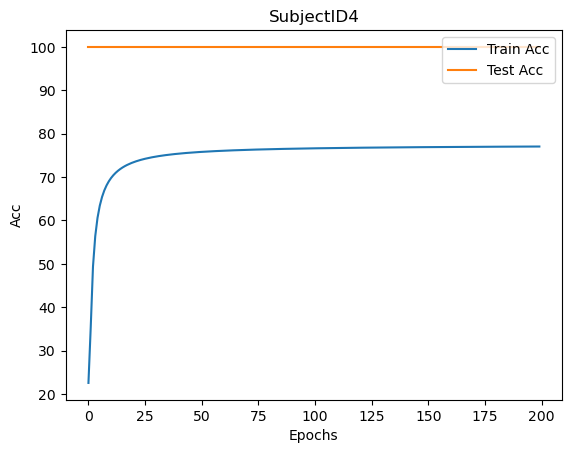


Subject 5
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3909 s/epoch | train loss 0.5088
| epoch   1 | 0.3885 s/epoch | train loss 0.4101
| epoch   2 | 0.3821 s/epoch | train loss 0.4003
| epoch   3 | 0.3782 s/epoch | train loss 0.4272
| epoch   4 | 0.3581 s/epoch | train loss 0.3699
| epoch   5 | 0.3478 s/epoch | train loss 0.3295
| epoch   6 | 0.3012 s/epoch | train loss 0.3298
| epoch   7 | 0.3037 s/epoch | train loss 0.2929
| epoch   8 | 0.3054 s/epoch | train loss 0.2831
| epoch   9 | 0.3072 s/epoch | train loss 0.3004
| epoch  10 | 0.3151 s/epoch | train loss 0.3245
| epoch  11 | 0.3138 s/epoch | train loss 0.2786
| epoch  12 | 0.3142 s/epoch | train loss 0.2682
| epoch  13 | 0.3145 s/epoch | train loss 0.2711
| epoch  14 | 0.3147 s/epoch | train loss 0.2530
| epoch  15 | 0.3172 s/epoch | train loss 0.2422
| epoch

| epoch 163 | 0.3234 s/epoch | train loss 0.1154
| epoch 164 | 0.3250 s/epoch | train loss 0.1127
| epoch 165 | 0.3232 s/epoch | train loss 0.1089
| epoch 166 | 0.3224 s/epoch | train loss 0.0990
| epoch 167 | 0.3229 s/epoch | train loss 0.1066
| epoch 168 | 0.3221 s/epoch | train loss 0.1256
| epoch 169 | 0.3232 s/epoch | train loss 0.1274
| epoch 170 | 0.3246 s/epoch | train loss 0.1191
| epoch 171 | 0.3232 s/epoch | train loss 0.0912
| epoch 172 | 0.3236 s/epoch | train loss 0.0989
| epoch 173 | 0.3221 s/epoch | train loss 0.0985
| epoch 174 | 0.3226 s/epoch | train loss 0.0880
| epoch 175 | 0.3227 s/epoch | train loss 0.0820
| epoch 176 | 0.3247 s/epoch | train loss 0.1021
| epoch 177 | 0.3221 s/epoch | train loss 0.0954
| epoch 178 | 0.3222 s/epoch | train loss 0.0811
| epoch 179 | 0.3255 s/epoch | train loss 0.0840
| epoch 180 | 0.3229 s/epoch | train loss 0.0819
| epoch 181 | 0.3210 s/epoch | train loss 0.0863
| epoch 182 | 0.3191 s/epoch | train loss 0.0877
| epoch 183 | 0.3178

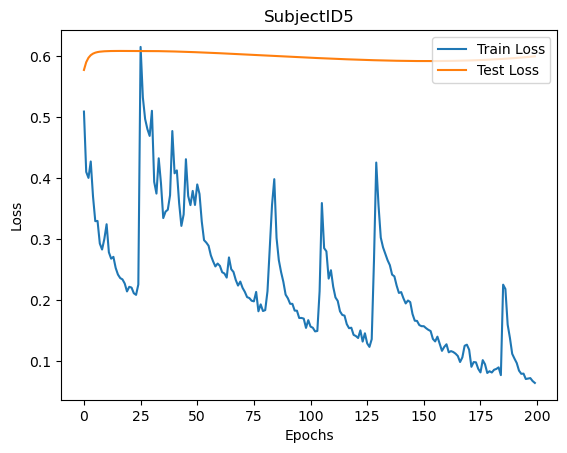

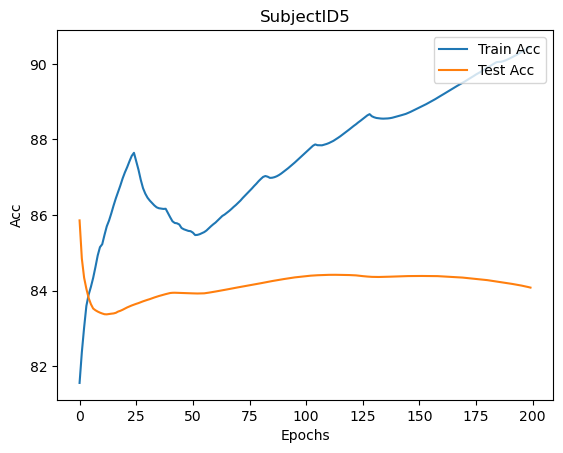

| epoch   0 | 0.0057 s/epoch | train loss 0.5272
| epoch   1 | 0.0057 s/epoch | train loss 0.5092
| epoch   2 | 0.0052 s/epoch | train loss 0.4789
| epoch   3 | 0.0053 s/epoch | train loss 0.4395
| epoch   4 | 0.0059 s/epoch | train loss 0.4106
| epoch   5 | 0.0057 s/epoch | train loss 0.3945
| epoch   6 | 0.0055 s/epoch | train loss 0.3869
| epoch   7 | 0.0056 s/epoch | train loss 0.3831
| epoch   8 | 0.0053 s/epoch | train loss 0.3797
| epoch   9 | 0.0054 s/epoch | train loss 0.3785
| epoch  10 | 0.0057 s/epoch | train loss 0.3764
| epoch  11 | 0.0056 s/epoch | train loss 0.3746
| epoch  12 | 0.0053 s/epoch | train loss 0.3733
| epoch  13 | 0.0049 s/epoch | train loss 0.3723
| epoch  14 | 0.0058 s/epoch | train loss 0.3720
| epoch  15 | 0.0057 s/epoch | train loss 0.3711
| epoch  16 | 0.0052 s/epoch | train loss 0.3713
| epoch  17 | 0.0057 s/epoch | train loss 0.3698
| epoch  18 | 0.0054 s/epoch | train loss 0.3695
| epoch  19 | 0.0051 s/epoch | train loss 0.3688
| epoch  20 | 0.0055

| epoch 168 | 0.0052 s/epoch | train loss 0.3536
| epoch 169 | 0.0054 s/epoch | train loss 0.3539
| epoch 170 | 0.0055 s/epoch | train loss 0.3544
| epoch 171 | 0.0057 s/epoch | train loss 0.3544
| epoch 172 | 0.0055 s/epoch | train loss 0.3536
| epoch 173 | 0.0053 s/epoch | train loss 0.3558
| epoch 174 | 0.0056 s/epoch | train loss 0.3543
| epoch 175 | 0.0060 s/epoch | train loss 0.3548
| epoch 176 | 0.0053 s/epoch | train loss 0.3537
| epoch 177 | 0.0054 s/epoch | train loss 0.3539
| epoch 178 | 0.0056 s/epoch | train loss 0.3535
| epoch 179 | 0.0056 s/epoch | train loss 0.3540
| epoch 180 | 0.0052 s/epoch | train loss 0.3544
| epoch 181 | 0.0060 s/epoch | train loss 0.3539
| epoch 182 | 0.0057 s/epoch | train loss 0.3535
| epoch 183 | 0.0054 s/epoch | train loss 0.3529
| epoch 184 | 0.0059 s/epoch | train loss 0.3536
| epoch 185 | 0.0059 s/epoch | train loss 0.3531
| epoch 186 | 0.0058 s/epoch | train loss 0.3533
| epoch 187 | 0.0059 s/epoch | train loss 0.3529
| epoch 188 | 0.0057

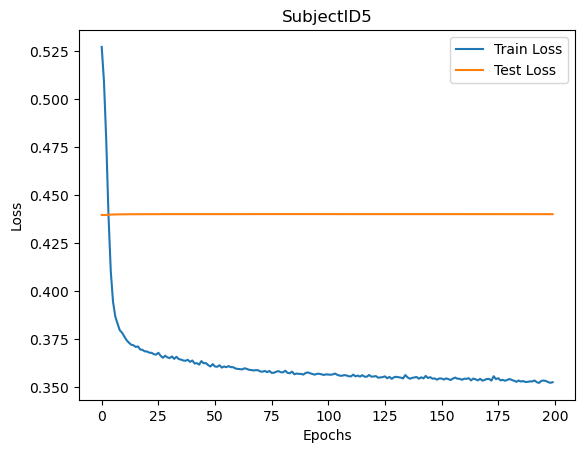

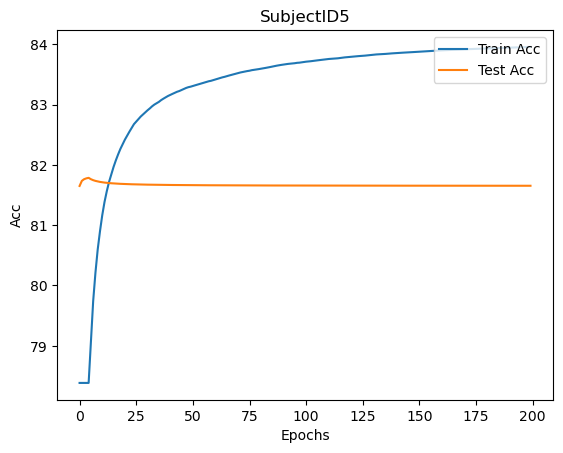


Subject 7
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3492 s/epoch | train loss 0.5210
| epoch   1 | 0.3655 s/epoch | train loss 0.3982
| epoch   2 | 0.3615 s/epoch | train loss 0.3160
| epoch   3 | 0.3604 s/epoch | train loss 0.3037
| epoch   4 | 0.3612 s/epoch | train loss 0.2928
| epoch   5 | 0.3693 s/epoch | train loss 0.2702
| epoch   6 | 0.3632 s/epoch | train loss 0.2535
| epoch   7 | 0.3631 s/epoch | train loss 0.2785
| epoch   8 | 0.3575 s/epoch | train loss 0.3039
| epoch   9 | 0.3567 s/epoch | train loss 0.2718
| epoch  10 | 0.3608 s/epoch | train loss 0.2604
| epoch  11 | 0.3668 s/epoch | train loss 0.2474
| epoch  12 | 0.3880 s/epoch | train loss 0.2384
| epoch  13 | 0.3719 s/epoch | train loss 0.2357
| epoch  14 | 0.3860 s/epoch | train loss 0.2284
| epoch  15 | 0.3907 s/epoch | train loss 0.2152
| epoch

| epoch 163 | 0.3072 s/epoch | train loss 0.0560
| epoch 164 | 0.3069 s/epoch | train loss 0.0592
| epoch 165 | 0.3075 s/epoch | train loss 0.0562
| epoch 166 | 0.3057 s/epoch | train loss 0.0465
| epoch 167 | 0.3067 s/epoch | train loss 0.0523
| epoch 168 | 0.3040 s/epoch | train loss 0.0512
| epoch 169 | 0.3088 s/epoch | train loss 0.0712
| epoch 170 | 0.3066 s/epoch | train loss 0.1209
| epoch 171 | 0.3079 s/epoch | train loss 0.0808
| epoch 172 | 0.3071 s/epoch | train loss 0.0632
| epoch 173 | 0.3069 s/epoch | train loss 0.0505
| epoch 174 | 0.3054 s/epoch | train loss 0.0525
| epoch 175 | 0.3064 s/epoch | train loss 0.0408
| epoch 176 | 0.3067 s/epoch | train loss 0.0378
| epoch 177 | 0.3061 s/epoch | train loss 0.0414
| epoch 178 | 0.3081 s/epoch | train loss 0.0465
| epoch 179 | 0.3081 s/epoch | train loss 0.0461
| epoch 180 | 0.3065 s/epoch | train loss 0.0480
| epoch 181 | 0.3055 s/epoch | train loss 0.0307
| epoch 182 | 0.3059 s/epoch | train loss 0.0361
| epoch 183 | 0.3057

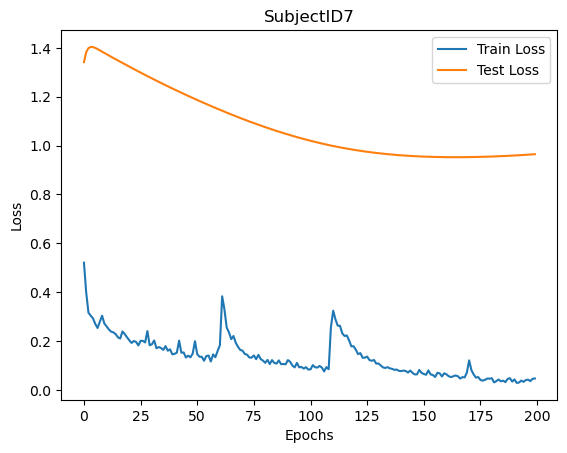

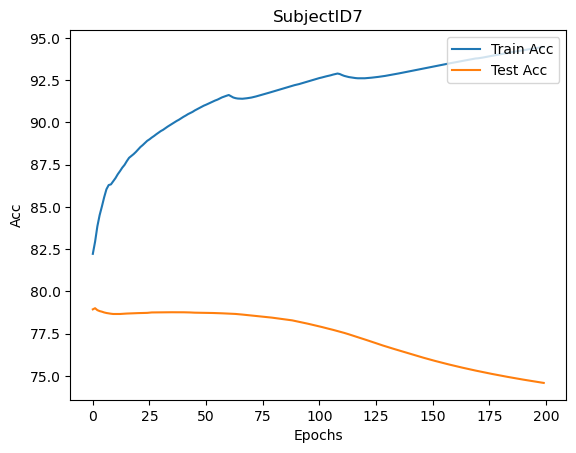

| epoch   0 | 0.0059 s/epoch | train loss 0.8171
| epoch   1 | 0.0057 s/epoch | train loss 0.6952
| epoch   2 | 0.0053 s/epoch | train loss 0.5827
| epoch   3 | 0.0053 s/epoch | train loss 0.5179
| epoch   4 | 0.0057 s/epoch | train loss 0.5007
| epoch   5 | 0.0055 s/epoch | train loss 0.4858
| epoch   6 | 0.0054 s/epoch | train loss 0.4692
| epoch   7 | 0.0054 s/epoch | train loss 0.4512
| epoch   8 | 0.0058 s/epoch | train loss 0.4326
| epoch   9 | 0.0056 s/epoch | train loss 0.4149
| epoch  10 | 0.0058 s/epoch | train loss 0.4000
| epoch  11 | 0.0054 s/epoch | train loss 0.3886
| epoch  12 | 0.0058 s/epoch | train loss 0.3817
| epoch  13 | 0.0055 s/epoch | train loss 0.3789
| epoch  14 | 0.0058 s/epoch | train loss 0.3773
| epoch  15 | 0.0053 s/epoch | train loss 0.3756
| epoch  16 | 0.0054 s/epoch | train loss 0.3748
| epoch  17 | 0.0052 s/epoch | train loss 0.3736
| epoch  18 | 0.0058 s/epoch | train loss 0.3733
| epoch  19 | 0.0053 s/epoch | train loss 0.3724
| epoch  20 | 0.0055

| epoch 168 | 0.0057 s/epoch | train loss 0.3584
| epoch 169 | 0.0056 s/epoch | train loss 0.3585
| epoch 170 | 0.0055 s/epoch | train loss 0.3585
| epoch 171 | 0.0059 s/epoch | train loss 0.3582
| epoch 172 | 0.0059 s/epoch | train loss 0.3583
| epoch 173 | 0.0052 s/epoch | train loss 0.3580
| epoch 174 | 0.0060 s/epoch | train loss 0.3583
| epoch 175 | 0.0051 s/epoch | train loss 0.3580
| epoch 176 | 0.0060 s/epoch | train loss 0.3579
| epoch 177 | 0.0054 s/epoch | train loss 0.3583
| epoch 178 | 0.0054 s/epoch | train loss 0.3580
| epoch 179 | 0.0055 s/epoch | train loss 0.3579
| epoch 180 | 0.0054 s/epoch | train loss 0.3576
| epoch 181 | 0.0057 s/epoch | train loss 0.3583
| epoch 182 | 0.0052 s/epoch | train loss 0.3577
| epoch 183 | 0.0055 s/epoch | train loss 0.3574
| epoch 184 | 0.0055 s/epoch | train loss 0.3580
| epoch 185 | 0.0056 s/epoch | train loss 0.3578
| epoch 186 | 0.0053 s/epoch | train loss 0.3568
| epoch 187 | 0.0052 s/epoch | train loss 0.3571
| epoch 188 | 0.0054

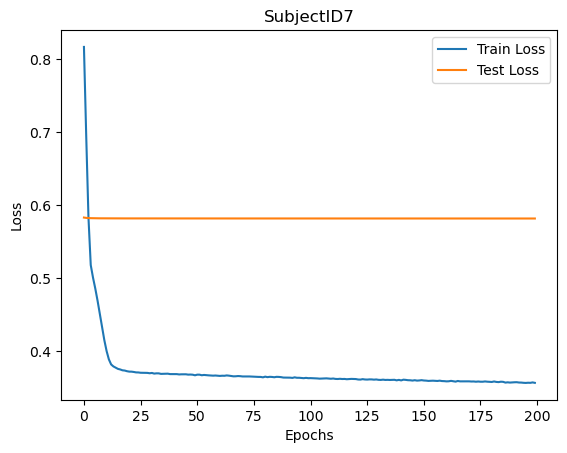

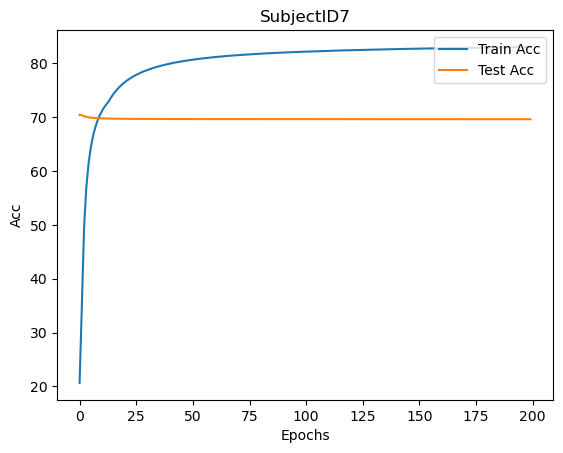


Subject 8
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3261 s/epoch | train loss 0.4493
| epoch   1 | 0.3245 s/epoch | train loss 0.3648
| epoch   2 | 0.3270 s/epoch | train loss 0.3340
| epoch   3 | 0.3257 s/epoch | train loss 0.3040
| epoch   4 | 0.3266 s/epoch | train loss 0.2847
| epoch   5 | 0.3272 s/epoch | train loss 0.2871
| epoch   6 | 0.3215 s/epoch | train loss 0.2780
| epoch   7 | 0.3117 s/epoch | train loss 0.2944
| epoch   8 | 0.3117 s/epoch | train loss 0.2527
| epoch   9 | 0.3130 s/epoch | train loss 0.2749
| epoch  10 | 0.3112 s/epoch | train loss 0.2433
| epoch  11 | 0.3117 s/epoch | train loss 0.3930
| epoch  12 | 0.3287 s/epoch | train loss 0.3814
| epoch  13 | 0.3254 s/epoch | train loss 0.3561
| epoch  14 | 0.3267 s/epoch | train loss 0.3463
| epoch  15 | 0.3263 s/epoch | train loss 0.3156
| epoch

| epoch 163 | 0.4125 s/epoch | train loss 0.0644
| epoch 164 | 0.4160 s/epoch | train loss 0.0630
| epoch 165 | 0.4374 s/epoch | train loss 0.0661
| epoch 166 | 0.4109 s/epoch | train loss 0.0575
| epoch 167 | 0.4468 s/epoch | train loss 0.0766
| epoch 168 | 0.4000 s/epoch | train loss 0.0707
| epoch 169 | 0.3355 s/epoch | train loss 0.0571
| epoch 170 | 0.3426 s/epoch | train loss 0.0571
| epoch 171 | 0.3383 s/epoch | train loss 0.0671
| epoch 172 | 0.3360 s/epoch | train loss 0.0698
| epoch 173 | 0.3336 s/epoch | train loss 0.0617
| epoch 174 | 0.3548 s/epoch | train loss 0.0579
| epoch 175 | 0.3309 s/epoch | train loss 0.0633
| epoch 176 | 0.3342 s/epoch | train loss 0.0489
| epoch 177 | 0.3327 s/epoch | train loss 0.0710
| epoch 178 | 0.3334 s/epoch | train loss 0.0586
| epoch 179 | 0.3449 s/epoch | train loss 0.0576
| epoch 180 | 0.4101 s/epoch | train loss 0.0529
| epoch 181 | 0.4119 s/epoch | train loss 0.0528
| epoch 182 | 0.4106 s/epoch | train loss 0.0538
| epoch 183 | 0.4089

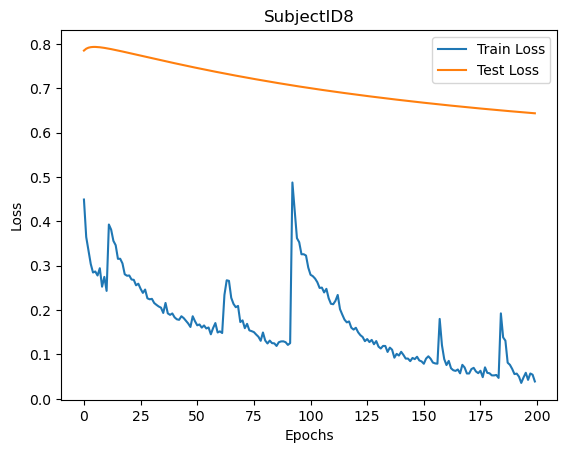

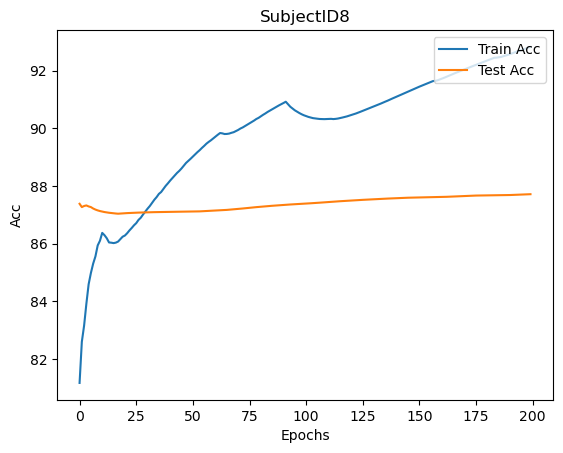

| epoch   0 | 0.0059 s/epoch | train loss 0.7451
| epoch   1 | 0.0060 s/epoch | train loss 0.6864
| epoch   2 | 0.0059 s/epoch | train loss 0.6416
| epoch   3 | 0.0062 s/epoch | train loss 0.6078
| epoch   4 | 0.0061 s/epoch | train loss 0.5830
| epoch   5 | 0.0061 s/epoch | train loss 0.5655
| epoch   6 | 0.0056 s/epoch | train loss 0.5529
| epoch   7 | 0.0060 s/epoch | train loss 0.5421
| epoch   8 | 0.0058 s/epoch | train loss 0.5295
| epoch   9 | 0.0060 s/epoch | train loss 0.5283
| epoch  10 | 0.0060 s/epoch | train loss 0.5285
| epoch  11 | 0.0059 s/epoch | train loss 0.5279
| epoch  12 | 0.0061 s/epoch | train loss 0.5282
| epoch  13 | 0.0055 s/epoch | train loss 0.5282
| epoch  14 | 0.0058 s/epoch | train loss 0.5279
| epoch  15 | 0.0059 s/epoch | train loss 0.5278
| epoch  16 | 0.0066 s/epoch | train loss 0.5283
| epoch  17 | 0.0062 s/epoch | train loss 0.5280
| epoch  18 | 0.0066 s/epoch | train loss 0.5282
| epoch  19 | 0.0067 s/epoch | train loss 0.5283
| epoch  20 | 0.0067

| epoch 168 | 0.0063 s/epoch | train loss 0.4049
| epoch 169 | 0.0064 s/epoch | train loss 0.4054
| epoch 170 | 0.0062 s/epoch | train loss 0.4049
| epoch 171 | 0.0064 s/epoch | train loss 0.4050
| epoch 172 | 0.0059 s/epoch | train loss 0.4056
| epoch 173 | 0.0059 s/epoch | train loss 0.4054
| epoch 174 | 0.0061 s/epoch | train loss 0.4054
| epoch 175 | 0.0063 s/epoch | train loss 0.4055
| epoch 176 | 0.0060 s/epoch | train loss 0.4048
| epoch 177 | 0.0060 s/epoch | train loss 0.4047
| epoch 178 | 0.0063 s/epoch | train loss 0.4050
| epoch 179 | 0.0058 s/epoch | train loss 0.4055
| epoch 180 | 0.0071 s/epoch | train loss 0.4056
| epoch 181 | 0.0064 s/epoch | train loss 0.4055
| epoch 182 | 0.0062 s/epoch | train loss 0.4044
| epoch 183 | 0.0059 s/epoch | train loss 0.4060
| epoch 184 | 0.0063 s/epoch | train loss 0.4048
| epoch 185 | 0.0063 s/epoch | train loss 0.4045
| epoch 186 | 0.0065 s/epoch | train loss 0.4050
| epoch 187 | 0.0062 s/epoch | train loss 0.4050
| epoch 188 | 0.0064

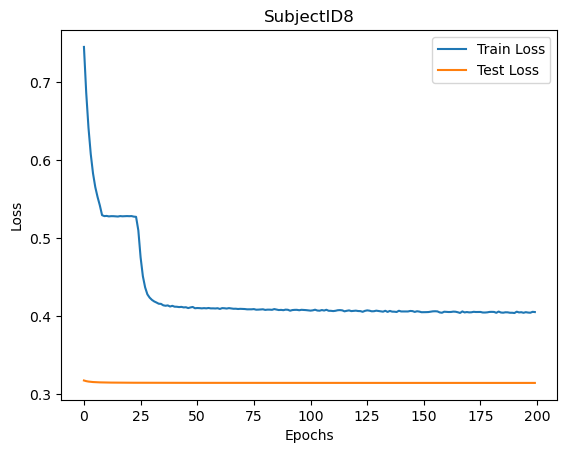

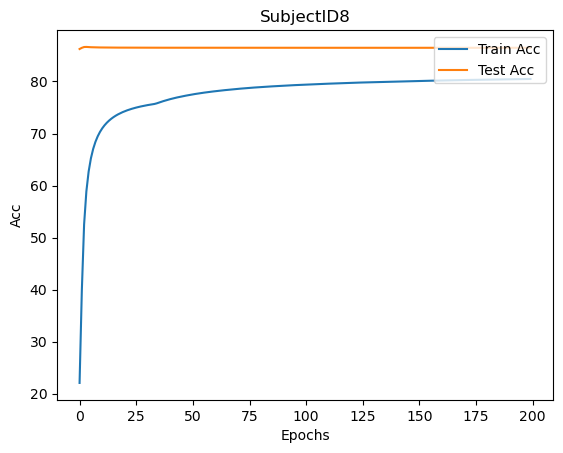


Subject 9
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3262 s/epoch | train loss 0.5248
| epoch   1 | 0.3257 s/epoch | train loss 0.3735
| epoch   2 | 0.3246 s/epoch | train loss 0.3509
| epoch   3 | 0.3269 s/epoch | train loss 0.3697
| epoch   4 | 0.3253 s/epoch | train loss 0.3610
| epoch   5 | 0.3249 s/epoch | train loss 0.3179
| epoch   6 | 0.3233 s/epoch | train loss 0.2871
| epoch   7 | 0.3164 s/epoch | train loss 0.2744
| epoch   8 | 0.3190 s/epoch | train loss 0.2742
| epoch   9 | 0.3266 s/epoch | train loss 0.2909
| epoch  10 | 0.3227 s/epoch | train loss 0.2806
| epoch  11 | 0.3108 s/epoch | train loss 0.2604
| epoch  12 | 0.3086 s/epoch | train loss 0.2485
| epoch  13 | 0.3302 s/epoch | train loss 0.2363
| epoch  14 | 0.3272 s/epoch | train loss 0.2358
| epoch  15 | 0.3251 s/epoch | train loss 0.2215
| epoch

| epoch 163 | 0.4130 s/epoch | train loss 0.1096
| epoch 164 | 0.4095 s/epoch | train loss 0.1032
| epoch 165 | 0.4098 s/epoch | train loss 0.1022
| epoch 166 | 0.3859 s/epoch | train loss 0.0996
| epoch 167 | 0.3521 s/epoch | train loss 0.1012
| epoch 168 | 0.3844 s/epoch | train loss 0.3043
| epoch 169 | 0.3927 s/epoch | train loss 0.3551
| epoch 170 | 0.4020 s/epoch | train loss 0.2959
| epoch 171 | 0.4045 s/epoch | train loss 0.2526
| epoch 172 | 0.4245 s/epoch | train loss 0.2234
| epoch 173 | 0.4160 s/epoch | train loss 0.2066
| epoch 174 | 0.4293 s/epoch | train loss 0.1930
| epoch 175 | 0.4208 s/epoch | train loss 0.1738
| epoch 176 | 0.4247 s/epoch | train loss 0.1656
| epoch 177 | 0.4183 s/epoch | train loss 0.1495
| epoch 178 | 0.4188 s/epoch | train loss 0.1366
| epoch 179 | 0.4195 s/epoch | train loss 0.1294
| epoch 180 | 0.4184 s/epoch | train loss 0.1315
| epoch 181 | 0.4074 s/epoch | train loss 0.1280
| epoch 182 | 0.4080 s/epoch | train loss 0.1112
| epoch 183 | 0.4014

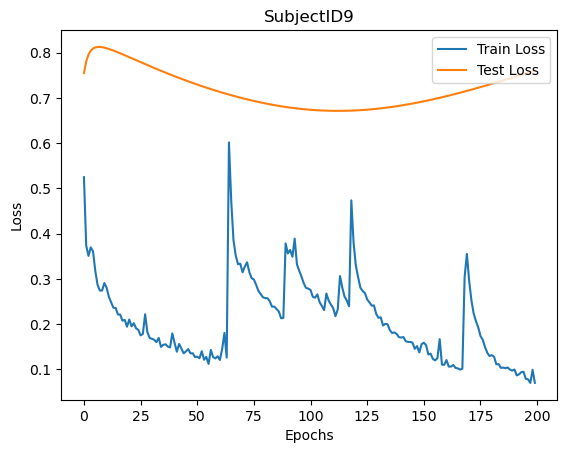

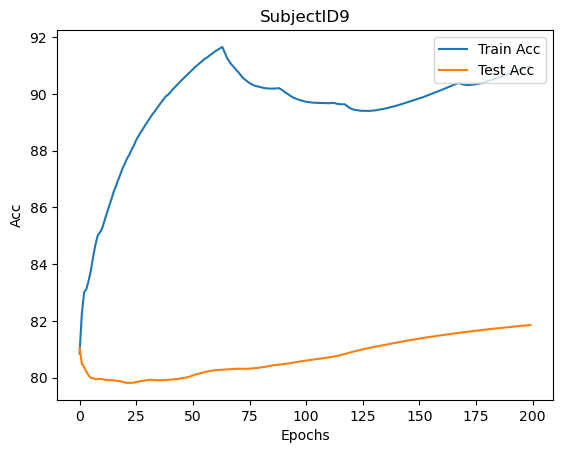

| epoch   0 | 0.0078 s/epoch | train loss 0.5383
| epoch   1 | 0.0083 s/epoch | train loss 0.5312
| epoch   2 | 0.0084 s/epoch | train loss 0.5281
| epoch   3 | 0.0080 s/epoch | train loss 0.5271
| epoch   4 | 0.0078 s/epoch | train loss 0.5267
| epoch   5 | 0.0081 s/epoch | train loss 0.5266
| epoch   6 | 0.0081 s/epoch | train loss 0.5265
| epoch   7 | 0.0085 s/epoch | train loss 0.5265
| epoch   8 | 0.0077 s/epoch | train loss 0.5264
| epoch   9 | 0.0080 s/epoch | train loss 0.5265
| epoch  10 | 0.0081 s/epoch | train loss 0.5264
| epoch  11 | 0.0077 s/epoch | train loss 0.5265
| epoch  12 | 0.0088 s/epoch | train loss 0.5266
| epoch  13 | 0.0080 s/epoch | train loss 0.5265
| epoch  14 | 0.0078 s/epoch | train loss 0.5266
| epoch  15 | 0.0082 s/epoch | train loss 0.5265
| epoch  16 | 0.0079 s/epoch | train loss 0.5265
| epoch  17 | 0.0083 s/epoch | train loss 0.5265
| epoch  18 | 0.0075 s/epoch | train loss 0.5265
| epoch  19 | 0.0075 s/epoch | train loss 0.5265
| epoch  20 | 0.0077

| epoch 168 | 0.0077 s/epoch | train loss 0.5264
| epoch 169 | 0.0079 s/epoch | train loss 0.5265
| epoch 170 | 0.0075 s/epoch | train loss 0.5265
| epoch 171 | 0.0075 s/epoch | train loss 0.5263
| epoch 172 | 0.0072 s/epoch | train loss 0.5265
| epoch 173 | 0.0075 s/epoch | train loss 0.5264
| epoch 174 | 0.0078 s/epoch | train loss 0.5265
| epoch 175 | 0.0076 s/epoch | train loss 0.5265
| epoch 176 | 0.0077 s/epoch | train loss 0.5265
| epoch 177 | 0.0079 s/epoch | train loss 0.5265
| epoch 178 | 0.0073 s/epoch | train loss 0.5265
| epoch 179 | 0.0072 s/epoch | train loss 0.5265
| epoch 180 | 0.0078 s/epoch | train loss 0.5265
| epoch 181 | 0.0077 s/epoch | train loss 0.5264
| epoch 182 | 0.0074 s/epoch | train loss 0.5264
| epoch 183 | 0.0084 s/epoch | train loss 0.5265
| epoch 184 | 0.0077 s/epoch | train loss 0.5266
| epoch 185 | 0.0080 s/epoch | train loss 0.5266
| epoch 186 | 0.0078 s/epoch | train loss 0.5264
| epoch 187 | 0.0079 s/epoch | train loss 0.5264
| epoch 188 | 0.0078

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


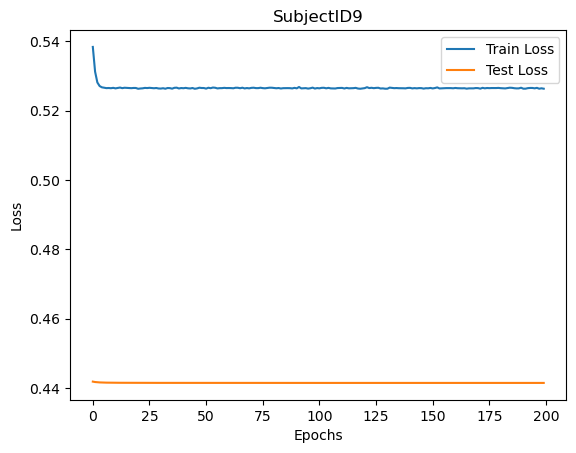

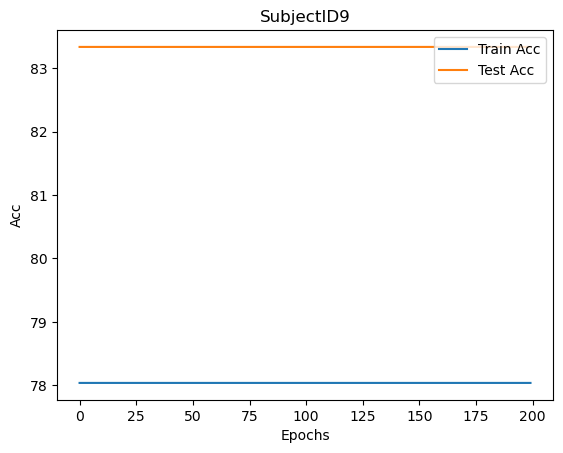


Subject 10
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.4107 s/epoch | train loss 0.4961
| epoch   1 | 0.4174 s/epoch | train loss 0.3679
| epoch   2 | 0.4103 s/epoch | train loss 0.3203
| epoch   3 | 0.4157 s/epoch | train loss 0.3058
| epoch   4 | 0.4074 s/epoch | train loss 0.2829
| epoch   5 | 0.4028 s/epoch | train loss 0.2741
| epoch   6 | 0.4152 s/epoch | train loss 0.2708
| epoch   7 | 0.4099 s/epoch | train loss 0.2715
| epoch   8 | 0.3847 s/epoch | train loss 0.2442
| epoch   9 | 0.3848 s/epoch | train loss 0.2437
| epoch  10 | 0.3776 s/epoch | train loss 0.2416
| epoch  11 | 0.3848 s/epoch | train loss 0.2337
| epoch  12 | 0.3804 s/epoch | train loss 0.2476
| epoch  13 | 0.3930 s/epoch | train loss 0.2350
| epoch  14 | 0.4253 s/epoch | train loss 0.2316
| epoch  15 | 0.4225 s/epoch | train loss 0.2329
| epoc

| epoch 163 | 0.3367 s/epoch | train loss 0.1329
| epoch 164 | 0.3373 s/epoch | train loss 0.0931
| epoch 165 | 0.3372 s/epoch | train loss 0.0717
| epoch 166 | 0.3357 s/epoch | train loss 0.0716
| epoch 167 | 0.3373 s/epoch | train loss 0.0675
| epoch 168 | 0.3347 s/epoch | train loss 0.0682
| epoch 169 | 0.3369 s/epoch | train loss 0.0712
| epoch 170 | 0.3348 s/epoch | train loss 0.0774
| epoch 171 | 0.3358 s/epoch | train loss 0.0640
| epoch 172 | 0.3371 s/epoch | train loss 0.0594
| epoch 173 | 0.3366 s/epoch | train loss 0.0587
| epoch 174 | 0.3354 s/epoch | train loss 0.0517
| epoch 175 | 0.3351 s/epoch | train loss 0.0578
| epoch 176 | 0.3373 s/epoch | train loss 0.0643
| epoch 177 | 0.3371 s/epoch | train loss 0.0650
| epoch 178 | 0.3374 s/epoch | train loss 0.0644
| epoch 179 | 0.3365 s/epoch | train loss 0.0449
| epoch 180 | 0.3355 s/epoch | train loss 0.0495
| epoch 181 | 0.3345 s/epoch | train loss 0.0479
| epoch 182 | 0.3367 s/epoch | train loss 0.0536
| epoch 183 | 0.3349

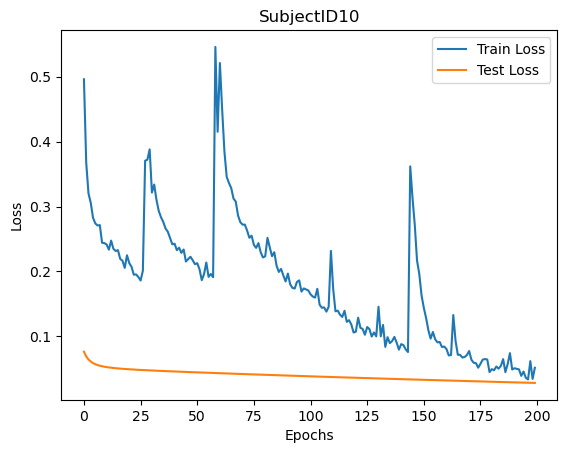

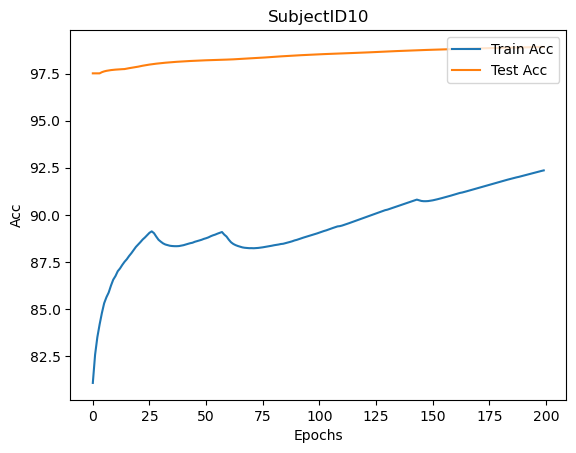

| epoch   0 | 0.0060 s/epoch | train loss 0.5403
| epoch   1 | 0.0058 s/epoch | train loss 0.5363
| epoch   2 | 0.0063 s/epoch | train loss 0.5305
| epoch   3 | 0.0055 s/epoch | train loss 0.4963
| epoch   4 | 0.0060 s/epoch | train loss 0.4608
| epoch   5 | 0.0064 s/epoch | train loss 0.4438
| epoch   6 | 0.0060 s/epoch | train loss 0.4330
| epoch   7 | 0.0063 s/epoch | train loss 0.4255
| epoch   8 | 0.0059 s/epoch | train loss 0.4198
| epoch   9 | 0.0061 s/epoch | train loss 0.4174
| epoch  10 | 0.0057 s/epoch | train loss 0.4129
| epoch  11 | 0.0059 s/epoch | train loss 0.4105
| epoch  12 | 0.0058 s/epoch | train loss 0.4083
| epoch  13 | 0.0059 s/epoch | train loss 0.4046
| epoch  14 | 0.0060 s/epoch | train loss 0.4032
| epoch  15 | 0.0060 s/epoch | train loss 0.4022
| epoch  16 | 0.0060 s/epoch | train loss 0.4020
| epoch  17 | 0.0060 s/epoch | train loss 0.3989
| epoch  18 | 0.0059 s/epoch | train loss 0.3986
| epoch  19 | 0.0059 s/epoch | train loss 0.3980
| epoch  20 | 0.0060

| epoch 168 | 0.0061 s/epoch | train loss 0.3721
| epoch 169 | 0.0061 s/epoch | train loss 0.3725
| epoch 170 | 0.0060 s/epoch | train loss 0.3719
| epoch 171 | 0.0060 s/epoch | train loss 0.3715
| epoch 172 | 0.0058 s/epoch | train loss 0.3721
| epoch 173 | 0.0058 s/epoch | train loss 0.3734
| epoch 174 | 0.0060 s/epoch | train loss 0.3728
| epoch 175 | 0.0062 s/epoch | train loss 0.3717
| epoch 176 | 0.0062 s/epoch | train loss 0.3739
| epoch 177 | 0.0062 s/epoch | train loss 0.3731
| epoch 178 | 0.0056 s/epoch | train loss 0.3722
| epoch 179 | 0.0062 s/epoch | train loss 0.3722
| epoch 180 | 0.0060 s/epoch | train loss 0.3732
| epoch 181 | 0.0061 s/epoch | train loss 0.3717
| epoch 182 | 0.0060 s/epoch | train loss 0.3716
| epoch 183 | 0.0063 s/epoch | train loss 0.3728
| epoch 184 | 0.0060 s/epoch | train loss 0.3718
| epoch 185 | 0.0066 s/epoch | train loss 0.3721
| epoch 186 | 0.0058 s/epoch | train loss 0.3729
| epoch 187 | 0.0062 s/epoch | train loss 0.3709
| epoch 188 | 0.0057

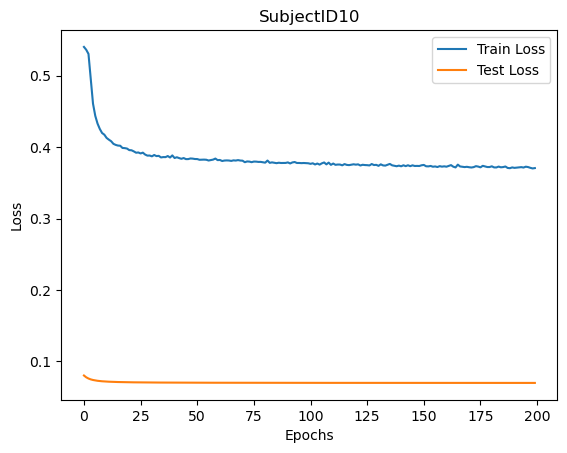

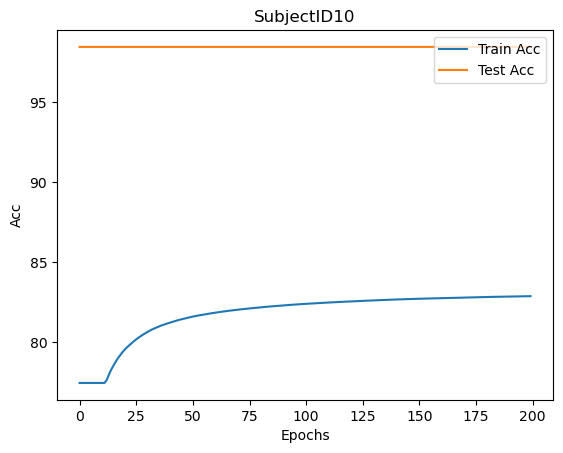


Subject 11
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3313 s/epoch | train loss 0.5506
| epoch   1 | 0.3322 s/epoch | train loss 0.3569
| epoch   2 | 0.3305 s/epoch | train loss 0.3391
| epoch   3 | 0.3323 s/epoch | train loss 0.3172
| epoch   4 | 0.3301 s/epoch | train loss 0.2928
| epoch   5 | 0.3322 s/epoch | train loss 0.2751
| epoch   6 | 0.3307 s/epoch | train loss 0.2899
| epoch   7 | 0.3294 s/epoch | train loss 0.2645
| epoch   8 | 0.3319 s/epoch | train loss 0.2636
| epoch   9 | 0.3269 s/epoch | train loss 0.2782
| epoch  10 | 0.3178 s/epoch | train loss 0.2615
| epoch  11 | 0.3145 s/epoch | train loss 0.2717
| epoch  12 | 0.3161 s/epoch | train loss 0.2401
| epoch  13 | 0.3146 s/epoch | train loss 0.2486
| epoch  14 | 0.3184 s/epoch | train loss 0.2244
| epoch  15 | 0.3313 s/epoch | train loss 0.2256
| epoc

| epoch 163 | 0.4020 s/epoch | train loss 0.1687
| epoch 164 | 0.4126 s/epoch | train loss 0.1645
| epoch 165 | 0.4102 s/epoch | train loss 0.1623
| epoch 166 | 0.4067 s/epoch | train loss 0.1617
| epoch 167 | 0.5842 s/epoch | train loss 0.1513
| epoch 168 | 0.4087 s/epoch | train loss 0.1602
| epoch 169 | 0.4472 s/epoch | train loss 0.1375
| epoch 170 | 0.5046 s/epoch | train loss 0.1346
| epoch 171 | 0.3983 s/epoch | train loss 0.1450
| epoch 172 | 0.5259 s/epoch | train loss 0.1242
| epoch 173 | 0.4061 s/epoch | train loss 0.1388
| epoch 174 | 0.4011 s/epoch | train loss 0.1240
| epoch 175 | 0.3951 s/epoch | train loss 0.1221
| epoch 176 | 0.3814 s/epoch | train loss 0.1212
| epoch 177 | 0.3614 s/epoch | train loss 0.1318
| epoch 178 | 0.3369 s/epoch | train loss 0.1235
| epoch 179 | 0.3375 s/epoch | train loss 0.1328
| epoch 180 | 0.3382 s/epoch | train loss 0.1108
| epoch 181 | 0.3394 s/epoch | train loss 0.1161
| epoch 182 | 0.3376 s/epoch | train loss 0.1100
| epoch 183 | 0.3350

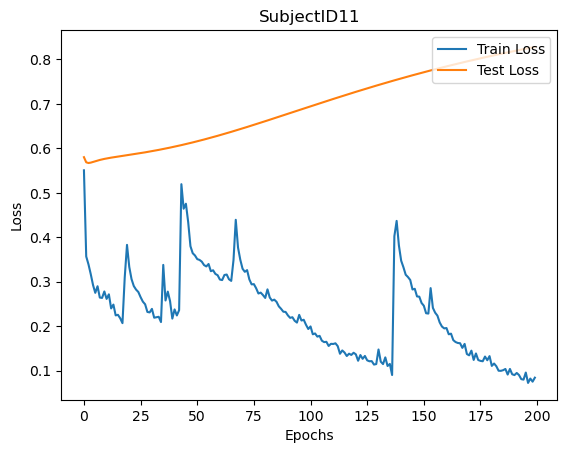

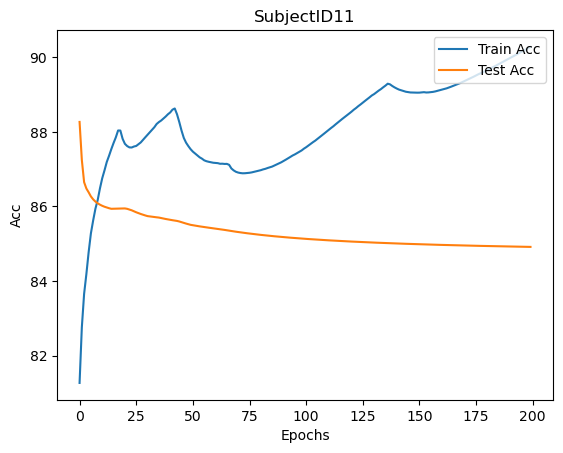

| epoch   0 | 0.0065 s/epoch | train loss 0.5953
| epoch   1 | 0.0061 s/epoch | train loss 0.5665
| epoch   2 | 0.0061 s/epoch | train loss 0.5486
| epoch   3 | 0.0064 s/epoch | train loss 0.5378
| epoch   4 | 0.0058 s/epoch | train loss 0.5316
| epoch   5 | 0.0066 s/epoch | train loss 0.5286
| epoch   6 | 0.0059 s/epoch | train loss 0.5268
| epoch   7 | 0.0061 s/epoch | train loss 0.5275
| epoch   8 | 0.0063 s/epoch | train loss 0.5244
| epoch   9 | 0.0061 s/epoch | train loss 0.5248
| epoch  10 | 0.0060 s/epoch | train loss 0.5252
| epoch  11 | 0.0060 s/epoch | train loss 0.5252
| epoch  12 | 0.0061 s/epoch | train loss 0.5257
| epoch  13 | 0.0058 s/epoch | train loss 0.5246
| epoch  14 | 0.0059 s/epoch | train loss 0.5252
| epoch  15 | 0.0058 s/epoch | train loss 0.5252
| epoch  16 | 0.0062 s/epoch | train loss 0.5252
| epoch  17 | 0.0057 s/epoch | train loss 0.5274
| epoch  18 | 0.0059 s/epoch | train loss 0.5263
| epoch  19 | 0.0067 s/epoch | train loss 0.5252
| epoch  20 | 0.0055

| epoch 168 | 0.0055 s/epoch | train loss 0.5246
| epoch 169 | 0.0063 s/epoch | train loss 0.5252
| epoch 170 | 0.0058 s/epoch | train loss 0.5252
| epoch 171 | 0.0060 s/epoch | train loss 0.5257
| epoch 172 | 0.0053 s/epoch | train loss 0.5246
| epoch 173 | 0.0056 s/epoch | train loss 0.5246
| epoch 174 | 0.0054 s/epoch | train loss 0.5257
| epoch 175 | 0.0061 s/epoch | train loss 0.5263
| epoch 176 | 0.0062 s/epoch | train loss 0.5252
| epoch 177 | 0.0062 s/epoch | train loss 0.5257
| epoch 178 | 0.0061 s/epoch | train loss 0.5246
| epoch 179 | 0.0065 s/epoch | train loss 0.5252
| epoch 180 | 0.0059 s/epoch | train loss 0.5263
| epoch 181 | 0.0057 s/epoch | train loss 0.5263
| epoch 182 | 0.0059 s/epoch | train loss 0.5246
| epoch 183 | 0.0059 s/epoch | train loss 0.5274
| epoch 184 | 0.0060 s/epoch | train loss 0.5252
| epoch 185 | 0.0055 s/epoch | train loss 0.5263
| epoch 186 | 0.0056 s/epoch | train loss 0.5269
| epoch 187 | 0.0057 s/epoch | train loss 0.5257
| epoch 188 | 0.0054

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


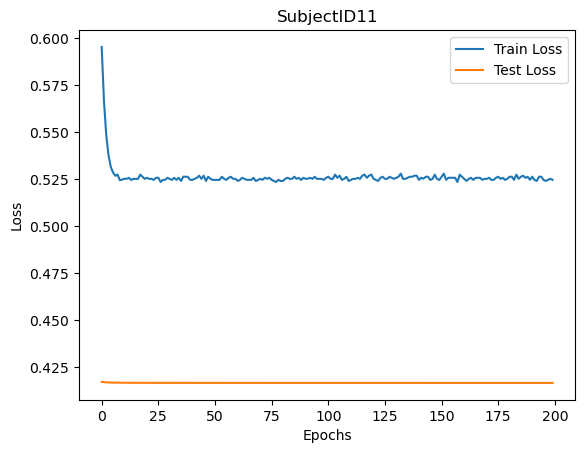

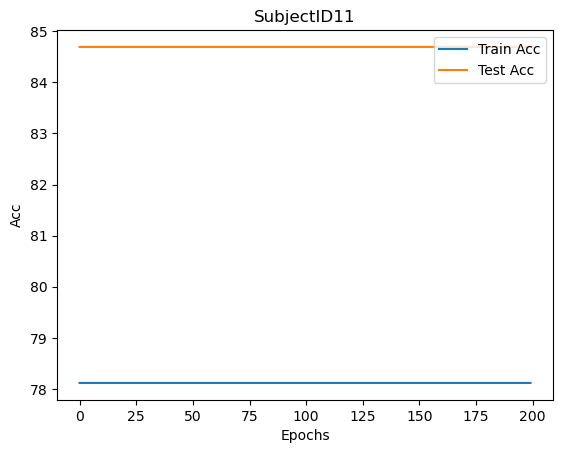


Subject 12
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3100 s/epoch | train loss 0.5158
| epoch   1 | 0.3057 s/epoch | train loss 0.3644
| epoch   2 | 0.3081 s/epoch | train loss 0.3283
| epoch   3 | 0.3056 s/epoch | train loss 0.3194
| epoch   4 | 0.4074 s/epoch | train loss 0.2936
| epoch   5 | 0.3086 s/epoch | train loss 0.2756
| epoch   6 | 0.3131 s/epoch | train loss 0.2689
| epoch   7 | 0.3157 s/epoch | train loss 0.2551
| epoch   8 | 0.3578 s/epoch | train loss 0.2710
| epoch   9 | 0.3560 s/epoch | train loss 0.2405
| epoch  10 | 0.3119 s/epoch | train loss 0.2329
| epoch  11 | 0.3016 s/epoch | train loss 0.2300
| epoch  12 | 0.3039 s/epoch | train loss 0.3511
| epoch  13 | 0.3096 s/epoch | train loss 0.2968
| epoch  14 | 0.3037 s/epoch | train loss 0.3571
| epoch  15 | 0.3070 s/epoch | train loss 0.2877
| epoc

| epoch 163 | 0.3622 s/epoch | train loss 0.1004
| epoch 164 | 0.3568 s/epoch | train loss 0.1003
| epoch 165 | 0.3495 s/epoch | train loss 0.0906
| epoch 166 | 0.3522 s/epoch | train loss 0.0885
| epoch 167 | 0.3654 s/epoch | train loss 0.0979
| epoch 168 | 0.3696 s/epoch | train loss 0.1275
| epoch 169 | 0.3468 s/epoch | train loss 0.0850
| epoch 170 | 0.3494 s/epoch | train loss 0.0828
| epoch 171 | 0.3542 s/epoch | train loss 0.1011
| epoch 172 | 0.3465 s/epoch | train loss 0.0839
| epoch 173 | 0.3456 s/epoch | train loss 0.0729
| epoch 174 | 0.3455 s/epoch | train loss 0.0895
| epoch 175 | 0.3454 s/epoch | train loss 0.0822
| epoch 176 | 0.3473 s/epoch | train loss 0.0874
| epoch 177 | 0.3600 s/epoch | train loss 0.0849
| epoch 178 | 0.3543 s/epoch | train loss 0.0755
| epoch 179 | 0.3497 s/epoch | train loss 0.0707
| epoch 180 | 0.3588 s/epoch | train loss 0.0793
| epoch 181 | 0.3495 s/epoch | train loss 0.0811
| epoch 182 | 0.3478 s/epoch | train loss 0.1009
| epoch 183 | 0.3518

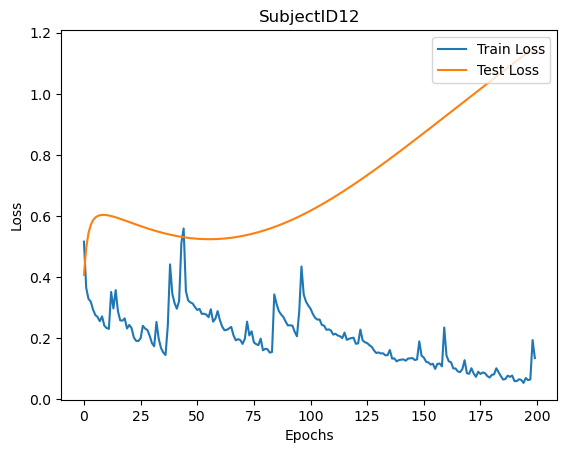

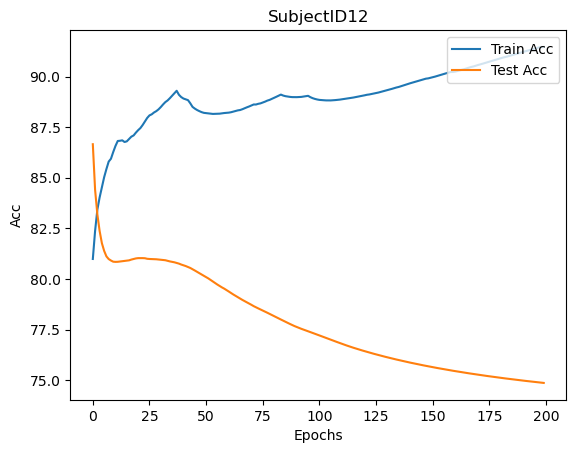

| epoch   0 | 0.0066 s/epoch | train loss 0.8465
| epoch   1 | 0.0068 s/epoch | train loss 0.6170
| epoch   2 | 0.0070 s/epoch | train loss 0.5105
| epoch   3 | 0.0072 s/epoch | train loss 0.4866
| epoch   4 | 0.0064 s/epoch | train loss 0.4714
| epoch   5 | 0.0066 s/epoch | train loss 0.4563
| epoch   6 | 0.0063 s/epoch | train loss 0.4384
| epoch   7 | 0.0065 s/epoch | train loss 0.4251
| epoch   8 | 0.0062 s/epoch | train loss 0.4158
| epoch   9 | 0.0067 s/epoch | train loss 0.4041
| epoch  10 | 0.0066 s/epoch | train loss 0.4005
| epoch  11 | 0.0061 s/epoch | train loss 0.3937
| epoch  12 | 0.0065 s/epoch | train loss 0.3940
| epoch  13 | 0.0067 s/epoch | train loss 0.3920
| epoch  14 | 0.0063 s/epoch | train loss 0.3942
| epoch  15 | 0.0065 s/epoch | train loss 0.3924
| epoch  16 | 0.0065 s/epoch | train loss 0.3911
| epoch  17 | 0.0067 s/epoch | train loss 0.3917
| epoch  18 | 0.0063 s/epoch | train loss 0.3901
| epoch  19 | 0.0066 s/epoch | train loss 0.3905
| epoch  20 | 0.0066

| epoch 168 | 0.0067 s/epoch | train loss 0.3785
| epoch 169 | 0.0066 s/epoch | train loss 0.3813
| epoch 170 | 0.0067 s/epoch | train loss 0.3796
| epoch 171 | 0.0067 s/epoch | train loss 0.3780
| epoch 172 | 0.0070 s/epoch | train loss 0.3769
| epoch 173 | 0.0066 s/epoch | train loss 0.3795
| epoch 174 | 0.0070 s/epoch | train loss 0.3785
| epoch 175 | 0.0069 s/epoch | train loss 0.3788
| epoch 176 | 0.0064 s/epoch | train loss 0.3795
| epoch 177 | 0.0066 s/epoch | train loss 0.3808
| epoch 178 | 0.0067 s/epoch | train loss 0.3787
| epoch 179 | 0.0065 s/epoch | train loss 0.3778
| epoch 180 | 0.0070 s/epoch | train loss 0.3778
| epoch 181 | 0.0065 s/epoch | train loss 0.3803
| epoch 182 | 0.0063 s/epoch | train loss 0.3810
| epoch 183 | 0.0066 s/epoch | train loss 0.3780
| epoch 184 | 0.0064 s/epoch | train loss 0.3812
| epoch 185 | 0.0065 s/epoch | train loss 0.3798
| epoch 186 | 0.0069 s/epoch | train loss 0.3784
| epoch 187 | 0.0068 s/epoch | train loss 0.3782
| epoch 188 | 0.0068

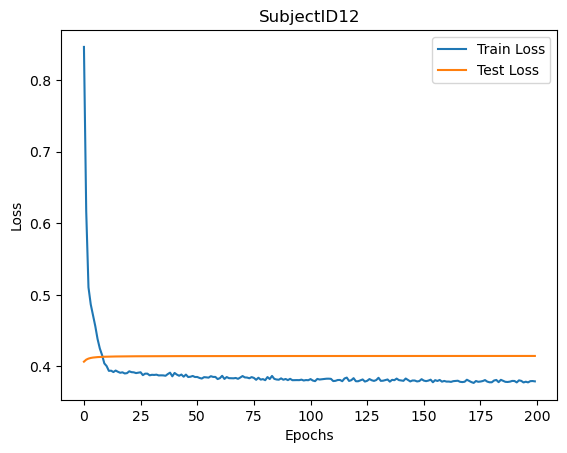

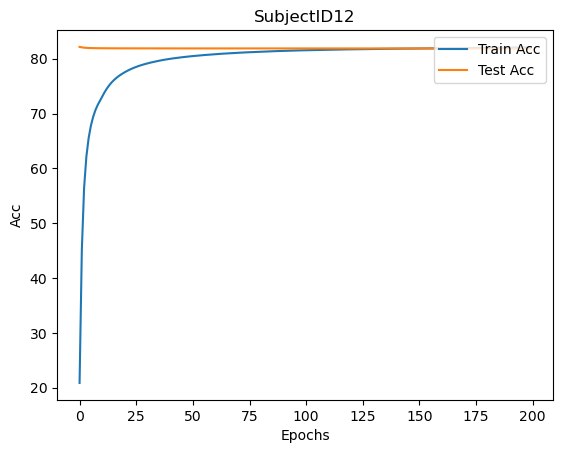


Subject 13
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3560 s/epoch | train loss 0.4797
| epoch   1 | 0.3545 s/epoch | train loss 0.3459
| epoch   2 | 0.3604 s/epoch | train loss 0.3515
| epoch   3 | 0.3588 s/epoch | train loss 0.3245
| epoch   4 | 0.3576 s/epoch | train loss 0.3172
| epoch   5 | 0.3585 s/epoch | train loss 0.2887
| epoch   6 | 0.3557 s/epoch | train loss 0.2806
| epoch   7 | 0.3649 s/epoch | train loss 0.2548
| epoch   8 | 0.3595 s/epoch | train loss 0.2618
| epoch   9 | 0.3556 s/epoch | train loss 0.2470
| epoch  10 | 0.3643 s/epoch | train loss 0.2269
| epoch  11 | 0.3568 s/epoch | train loss 0.2287
| epoch  12 | 0.3422 s/epoch | train loss 0.2225
| epoch  13 | 0.3468 s/epoch | train loss 0.2226
| epoch  14 | 0.3409 s/epoch | train loss 0.2105
| epoch  15 | 0.3370 s/epoch | train loss 0.2123
| epoc

| epoch 163 | 0.3119 s/epoch | train loss 0.2090
| epoch 164 | 0.3107 s/epoch | train loss 0.0951
| epoch 165 | 0.3110 s/epoch | train loss 0.0718
| epoch 166 | 0.3108 s/epoch | train loss 0.0501
| epoch 167 | 0.3121 s/epoch | train loss 0.0425
| epoch 168 | 0.3114 s/epoch | train loss 0.0414
| epoch 169 | 0.3102 s/epoch | train loss 0.0387
| epoch 170 | 0.3118 s/epoch | train loss 0.0375
| epoch 171 | 0.3121 s/epoch | train loss 0.0286
| epoch 172 | 0.2969 s/epoch | train loss 0.0343
| epoch 173 | 0.3785 s/epoch | train loss 0.0336
| epoch 174 | 0.3922 s/epoch | train loss 0.0447
| epoch 175 | 0.3769 s/epoch | train loss 0.0381
| epoch 176 | 0.3858 s/epoch | train loss 0.0365
| epoch 177 | 0.3797 s/epoch | train loss 0.0378
| epoch 178 | 0.3855 s/epoch | train loss 0.0257
| epoch 179 | 0.3816 s/epoch | train loss 0.0339
| epoch 180 | 0.3748 s/epoch | train loss 0.0315
| epoch 181 | 0.3710 s/epoch | train loss 0.0415
| epoch 182 | 0.3778 s/epoch | train loss 0.0239
| epoch 183 | 0.3759

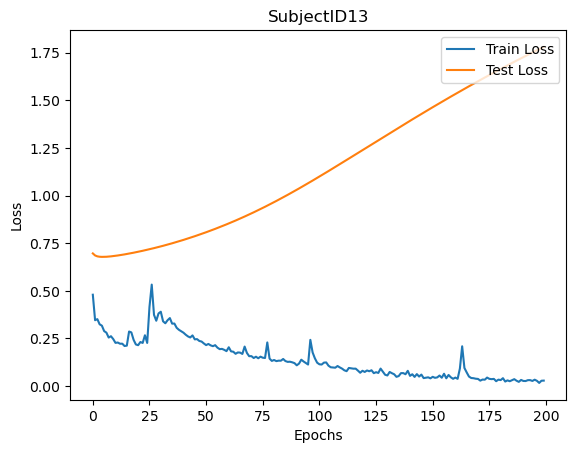

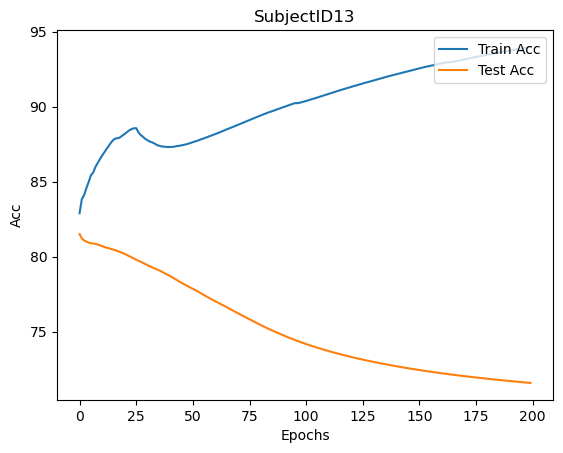

| epoch   0 | 0.0076 s/epoch | train loss 0.6424
| epoch   1 | 0.0075 s/epoch | train loss 0.5904
| epoch   2 | 0.0077 s/epoch | train loss 0.5630
| epoch   3 | 0.0079 s/epoch | train loss 0.5438
| epoch   4 | 0.0075 s/epoch | train loss 0.5309
| epoch   5 | 0.0076 s/epoch | train loss 0.5219
| epoch   6 | 0.0072 s/epoch | train loss 0.5153
| epoch   7 | 0.0078 s/epoch | train loss 0.5127
| epoch   8 | 0.0082 s/epoch | train loss 0.5097
| epoch   9 | 0.0077 s/epoch | train loss 0.5091
| epoch  10 | 0.0074 s/epoch | train loss 0.5071
| epoch  11 | 0.0072 s/epoch | train loss 0.5088
| epoch  12 | 0.0075 s/epoch | train loss 0.5064
| epoch  13 | 0.0077 s/epoch | train loss 0.5071
| epoch  14 | 0.0076 s/epoch | train loss 0.5061
| epoch  15 | 0.0081 s/epoch | train loss 0.5070
| epoch  16 | 0.0077 s/epoch | train loss 0.5065
| epoch  17 | 0.0084 s/epoch | train loss 0.5074
| epoch  18 | 0.0083 s/epoch | train loss 0.5070
| epoch  19 | 0.0080 s/epoch | train loss 0.5075
| epoch  20 | 0.0078

| epoch 168 | 0.0080 s/epoch | train loss 0.3810
| epoch 169 | 0.0075 s/epoch | train loss 0.3798
| epoch 170 | 0.0074 s/epoch | train loss 0.3792
| epoch 171 | 0.0077 s/epoch | train loss 0.3796
| epoch 172 | 0.0071 s/epoch | train loss 0.3788
| epoch 173 | 0.0071 s/epoch | train loss 0.3792
| epoch 174 | 0.0073 s/epoch | train loss 0.3798
| epoch 175 | 0.0077 s/epoch | train loss 0.3795
| epoch 176 | 0.0077 s/epoch | train loss 0.3783
| epoch 177 | 0.0074 s/epoch | train loss 0.3792
| epoch 178 | 0.0073 s/epoch | train loss 0.3779
| epoch 179 | 0.0075 s/epoch | train loss 0.3793
| epoch 180 | 0.0070 s/epoch | train loss 0.3793
| epoch 181 | 0.0077 s/epoch | train loss 0.3786
| epoch 182 | 0.0075 s/epoch | train loss 0.3791
| epoch 183 | 0.0067 s/epoch | train loss 0.3773
| epoch 184 | 0.0078 s/epoch | train loss 0.3779
| epoch 185 | 0.0075 s/epoch | train loss 0.3776
| epoch 186 | 0.0075 s/epoch | train loss 0.3797
| epoch 187 | 0.0074 s/epoch | train loss 0.3788
| epoch 188 | 0.0070

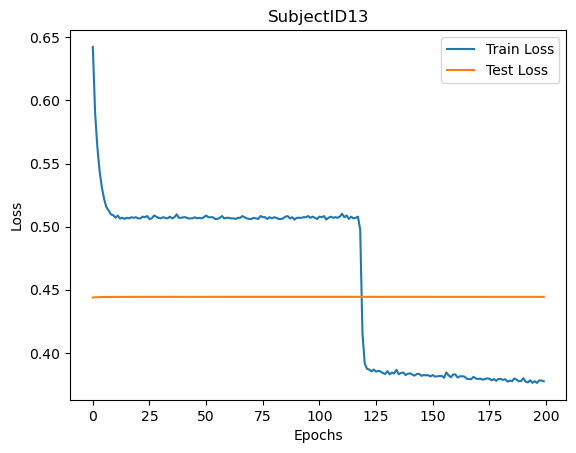

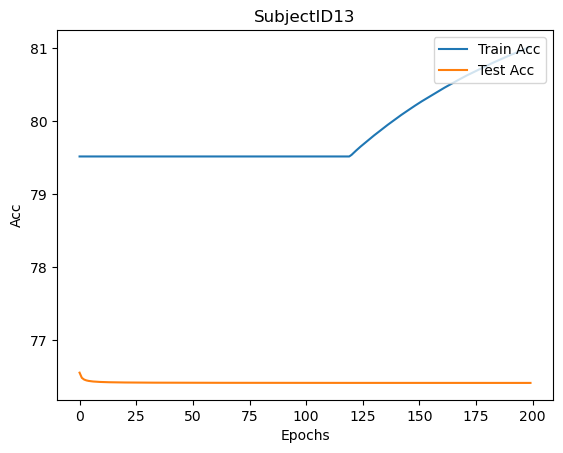


Subject 14
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.4118 s/epoch | train loss 0.4903
| epoch   1 | 0.3961 s/epoch | train loss 0.3868
| epoch   2 | 0.3968 s/epoch | train loss 0.3270
| epoch   3 | 0.3901 s/epoch | train loss 0.3432
| epoch   4 | 0.4041 s/epoch | train loss 0.3074
| epoch   5 | 0.4013 s/epoch | train loss 0.3340
| epoch   6 | 0.4009 s/epoch | train loss 0.3689
| epoch   7 | 0.4008 s/epoch | train loss 0.3383
| epoch   8 | 0.4003 s/epoch | train loss 0.4334
| epoch   9 | 0.4017 s/epoch | train loss 0.2739
| epoch  10 | 0.3975 s/epoch | train loss 0.2522
| epoch  11 | 0.3904 s/epoch | train loss 0.2551
| epoch  12 | 0.3761 s/epoch | train loss 0.2472
| epoch  13 | 0.3712 s/epoch | train loss 0.2348
| epoch  14 | 0.3746 s/epoch | train loss 0.3026
| epoch  15 | 0.3408 s/epoch | train loss 0.2750
| epoc

| epoch 163 | 0.3270 s/epoch | train loss 0.2647
| epoch 164 | 0.3260 s/epoch | train loss 0.2364
| epoch 165 | 0.3260 s/epoch | train loss 0.2711
| epoch 166 | 0.3252 s/epoch | train loss 0.3841
| epoch 167 | 0.3248 s/epoch | train loss 0.4166
| epoch 168 | 0.3262 s/epoch | train loss 0.3516
| epoch 169 | 0.3264 s/epoch | train loss 0.3115
| epoch 170 | 0.3259 s/epoch | train loss 0.2711
| epoch 171 | 0.3279 s/epoch | train loss 0.2806
| epoch 172 | 0.3256 s/epoch | train loss 0.2618
| epoch 173 | 0.3252 s/epoch | train loss 0.2393
| epoch 174 | 0.3273 s/epoch | train loss 0.2327
| epoch 175 | 0.3256 s/epoch | train loss 0.2157
| epoch 176 | 0.3266 s/epoch | train loss 0.2205
| epoch 177 | 0.3264 s/epoch | train loss 0.2114
| epoch 178 | 0.3265 s/epoch | train loss 0.2363
| epoch 179 | 0.3260 s/epoch | train loss 0.2148
| epoch 180 | 0.3264 s/epoch | train loss 0.1908
| epoch 181 | 0.3248 s/epoch | train loss 0.1899
| epoch 182 | 0.3248 s/epoch | train loss 0.2229
| epoch 183 | 0.3240

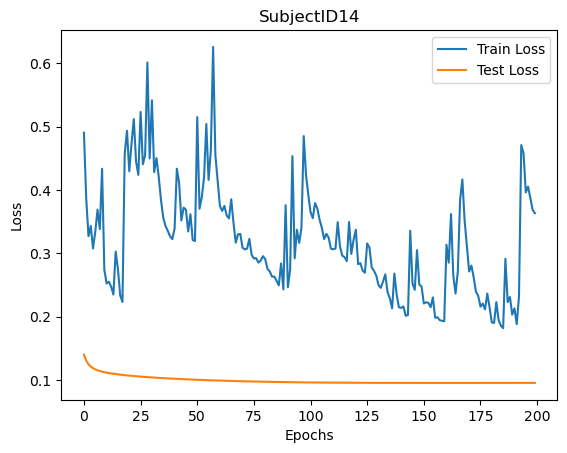

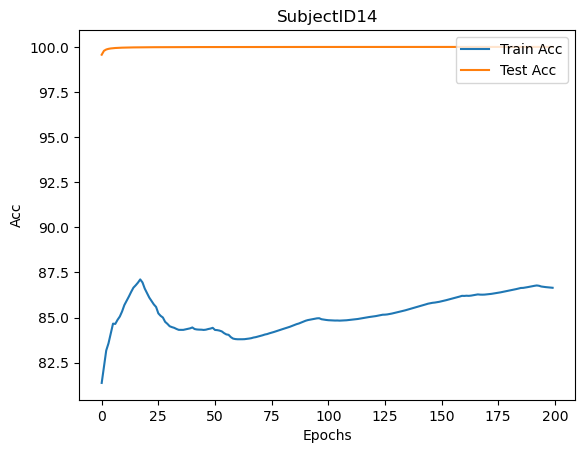

| epoch   0 | 0.0056 s/epoch | train loss 0.5409
| epoch   1 | 0.0061 s/epoch | train loss 0.5426
| epoch   2 | 0.0061 s/epoch | train loss 0.5372
| epoch   3 | 0.0054 s/epoch | train loss 0.5398
| epoch   4 | 0.0060 s/epoch | train loss 0.5371
| epoch   5 | 0.0054 s/epoch | train loss 0.5399
| epoch   6 | 0.0067 s/epoch | train loss 0.5398
| epoch   7 | 0.0057 s/epoch | train loss 0.5371
| epoch   8 | 0.0058 s/epoch | train loss 0.5371
| epoch   9 | 0.0057 s/epoch | train loss 0.5398
| epoch  10 | 0.0055 s/epoch | train loss 0.5372
| epoch  11 | 0.0056 s/epoch | train loss 0.5398
| epoch  12 | 0.0053 s/epoch | train loss 0.5398
| epoch  13 | 0.0060 s/epoch | train loss 0.5398
| epoch  14 | 0.0058 s/epoch | train loss 0.5399
| epoch  15 | 0.0057 s/epoch | train loss 0.5371
| epoch  16 | 0.0060 s/epoch | train loss 0.5371
| epoch  17 | 0.0058 s/epoch | train loss 0.5371
| epoch  18 | 0.0058 s/epoch | train loss 0.5425
| epoch  19 | 0.0057 s/epoch | train loss 0.5398
| epoch  20 | 0.0056

| epoch 168 | 0.0061 s/epoch | train loss 0.5425
| epoch 169 | 0.0064 s/epoch | train loss 0.5398
| epoch 170 | 0.0055 s/epoch | train loss 0.5372
| epoch 171 | 0.0054 s/epoch | train loss 0.5398
| epoch 172 | 0.0059 s/epoch | train loss 0.5398
| epoch 173 | 0.0056 s/epoch | train loss 0.5425
| epoch 174 | 0.0059 s/epoch | train loss 0.5372
| epoch 175 | 0.0061 s/epoch | train loss 0.5399
| epoch 176 | 0.0065 s/epoch | train loss 0.5372
| epoch 177 | 0.0060 s/epoch | train loss 0.5425
| epoch 178 | 0.0065 s/epoch | train loss 0.5372
| epoch 179 | 0.0061 s/epoch | train loss 0.5372
| epoch 180 | 0.0056 s/epoch | train loss 0.5398
| epoch 181 | 0.0056 s/epoch | train loss 0.5398
| epoch 182 | 0.0061 s/epoch | train loss 0.5398
| epoch 183 | 0.0058 s/epoch | train loss 0.5371
| epoch 184 | 0.0057 s/epoch | train loss 0.5371
| epoch 185 | 0.0062 s/epoch | train loss 0.5398
| epoch 186 | 0.0058 s/epoch | train loss 0.5398
| epoch 187 | 0.0055 s/epoch | train loss 0.5425
| epoch 188 | 0.0061

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


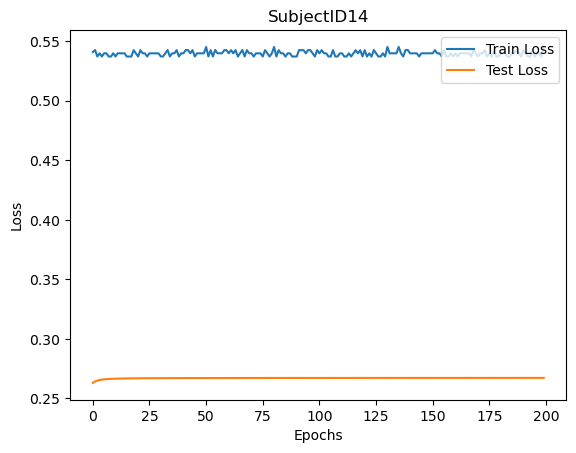

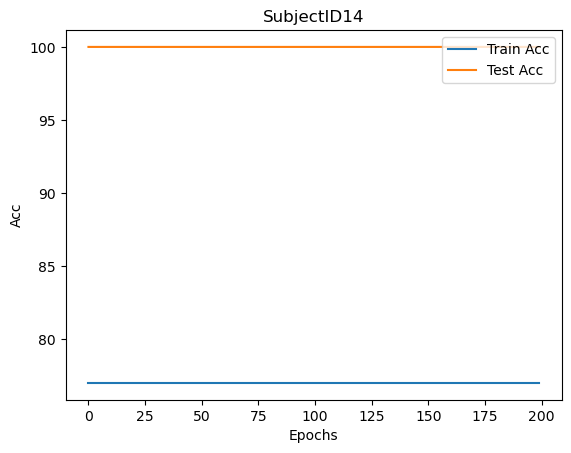


Subject 15
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.3403 s/epoch | train loss 0.5080
| epoch   1 | 0.3388 s/epoch | train loss 0.3337
| epoch   2 | 0.3384 s/epoch | train loss 0.3071
| epoch   3 | 0.3396 s/epoch | train loss 0.2919
| epoch   4 | 0.3389 s/epoch | train loss 0.2745
| epoch   5 | 0.3380 s/epoch | train loss 0.2596
| epoch   6 | 0.3391 s/epoch | train loss 0.2590
| epoch   7 | 0.3383 s/epoch | train loss 0.2475
| epoch   8 | 0.3380 s/epoch | train loss 0.2428
| epoch   9 | 0.3385 s/epoch | train loss 0.2346
| epoch  10 | 0.3371 s/epoch | train loss 0.2248
| epoch  11 | 0.3383 s/epoch | train loss 0.2227
| epoch  12 | 0.3340 s/epoch | train loss 0.2503
| epoch  13 | 0.3254 s/epoch | train loss 0.2066
| epoch  14 | 0.3234 s/epoch | train loss 0.2055
| epoch  15 | 0.3240 s/epoch | train loss 0.2051
| epoc

| epoch 163 | 0.3384 s/epoch | train loss 0.0546
| epoch 164 | 0.3408 s/epoch | train loss 0.0456
| epoch 165 | 0.3383 s/epoch | train loss 0.0351
| epoch 166 | 0.3391 s/epoch | train loss 0.0341
| epoch 167 | 0.3386 s/epoch | train loss 0.0666
| epoch 168 | 0.3388 s/epoch | train loss 0.0640
| epoch 169 | 0.3394 s/epoch | train loss 0.0339
| epoch 170 | 0.3394 s/epoch | train loss 0.0395
| epoch 171 | 0.3376 s/epoch | train loss 0.0329
| epoch 172 | 0.3410 s/epoch | train loss 0.0432
| epoch 173 | 0.3382 s/epoch | train loss 0.0363
| epoch 174 | 0.3380 s/epoch | train loss 0.0338
| epoch 175 | 0.3420 s/epoch | train loss 0.0343
| epoch 176 | 0.3393 s/epoch | train loss 0.0360
| epoch 177 | 0.3409 s/epoch | train loss 0.0429
| epoch 178 | 0.3406 s/epoch | train loss 0.0307
| epoch 179 | 0.3419 s/epoch | train loss 0.0353
| epoch 180 | 0.3393 s/epoch | train loss 0.0425
| epoch 181 | 0.3410 s/epoch | train loss 0.0264
| epoch 182 | 0.3393 s/epoch | train loss 0.0465
| epoch 183 | 0.3403

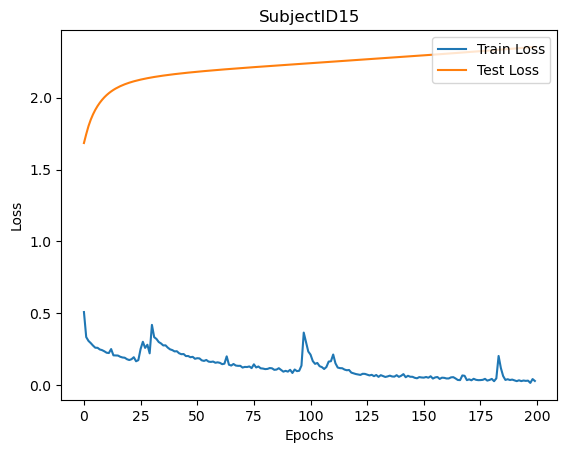

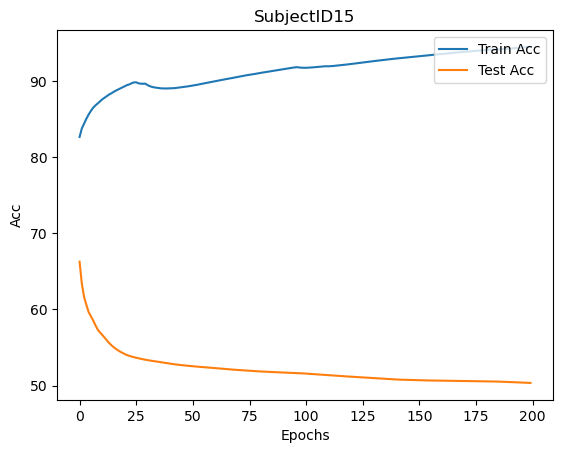

| epoch   0 | 0.0059 s/epoch | train loss 0.6904
| epoch   1 | 0.0061 s/epoch | train loss 0.5878
| epoch   2 | 0.0060 s/epoch | train loss 0.5183
| epoch   3 | 0.0060 s/epoch | train loss 0.5043
| epoch   4 | 0.0060 s/epoch | train loss 0.4923
| epoch   5 | 0.0064 s/epoch | train loss 0.4728
| epoch   6 | 0.0060 s/epoch | train loss 0.4480
| epoch   7 | 0.0059 s/epoch | train loss 0.4180
| epoch   8 | 0.0063 s/epoch | train loss 0.4029
| epoch   9 | 0.0061 s/epoch | train loss 0.3940
| epoch  10 | 0.0057 s/epoch | train loss 0.3896
| epoch  11 | 0.0064 s/epoch | train loss 0.3879
| epoch  12 | 0.0059 s/epoch | train loss 0.3859
| epoch  13 | 0.0060 s/epoch | train loss 0.3852
| epoch  14 | 0.0059 s/epoch | train loss 0.3850
| epoch  15 | 0.0064 s/epoch | train loss 0.3840
| epoch  16 | 0.0062 s/epoch | train loss 0.3835
| epoch  17 | 0.0061 s/epoch | train loss 0.3835
| epoch  18 | 0.0058 s/epoch | train loss 0.3832
| epoch  19 | 0.0060 s/epoch | train loss 0.3827
| epoch  20 | 0.0061

| epoch 168 | 0.0063 s/epoch | train loss 0.3472
| epoch 169 | 0.0064 s/epoch | train loss 0.3460
| epoch 170 | 0.0062 s/epoch | train loss 0.3459
| epoch 171 | 0.0069 s/epoch | train loss 0.3469
| epoch 172 | 0.0067 s/epoch | train loss 0.3453
| epoch 173 | 0.0066 s/epoch | train loss 0.3456
| epoch 174 | 0.0061 s/epoch | train loss 0.3445
| epoch 175 | 0.0064 s/epoch | train loss 0.3452
| epoch 176 | 0.0062 s/epoch | train loss 0.3454
| epoch 177 | 0.0062 s/epoch | train loss 0.3463
| epoch 178 | 0.0061 s/epoch | train loss 0.3451
| epoch 179 | 0.0062 s/epoch | train loss 0.3461
| epoch 180 | 0.0062 s/epoch | train loss 0.3457
| epoch 181 | 0.0057 s/epoch | train loss 0.3451
| epoch 182 | 0.0062 s/epoch | train loss 0.3456
| epoch 183 | 0.0062 s/epoch | train loss 0.3449
| epoch 184 | 0.0060 s/epoch | train loss 0.3459
| epoch 185 | 0.0060 s/epoch | train loss 0.3454
| epoch 186 | 0.0064 s/epoch | train loss 0.3456
| epoch 187 | 0.0062 s/epoch | train loss 0.3456
| epoch 188 | 0.0064

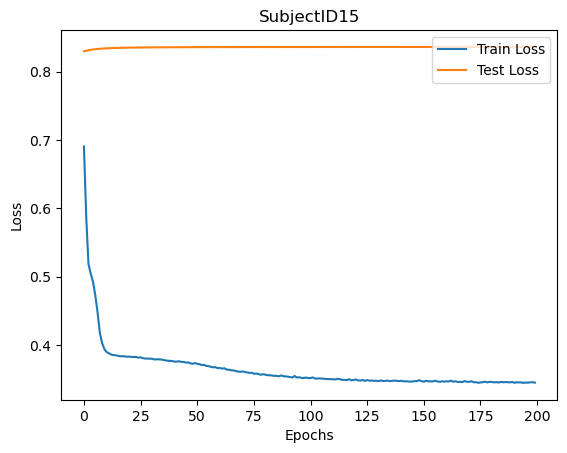

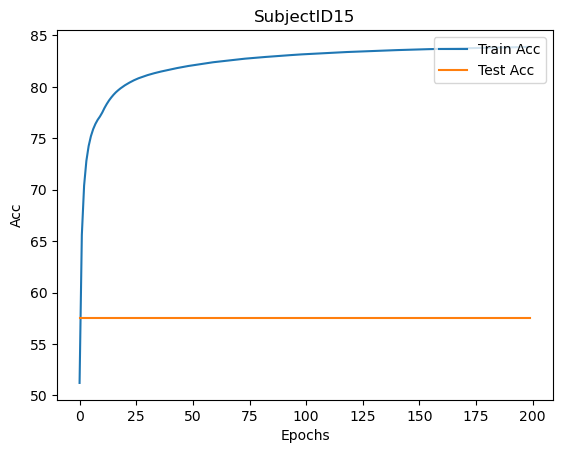

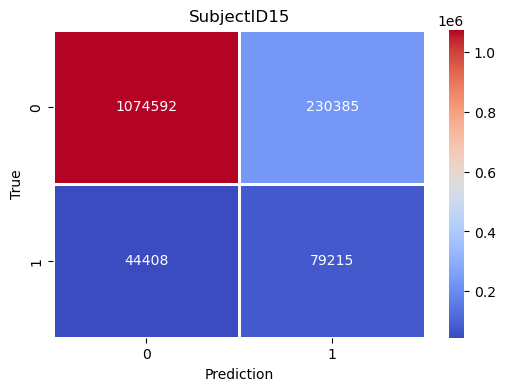

<Figure size 640x480 with 0 Axes>

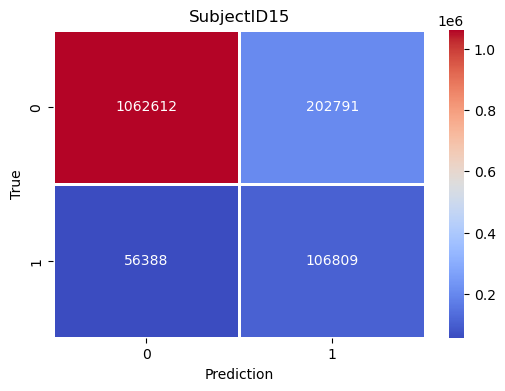

Teacher(RestNet50)_Acc: 0.8076487470250595
Teacher(RestNet50)_Rec: 0.6407788194753403
Teacher(RestNet50)_Pre: 0.2558624031007752
Teacher(RestNet50)_F1: 0.36570080535890287
Original_Student(CNN_Small)_Acc: 0.8185783284334314
Original_Student(CNN_Small)_Rec: 0.6544789426276219
Original_Student(CNN_Small)_Pre: 0.3449903100775194
Original_Student(CNN_Small)_F1: 0.45181758767504876


<Figure size 640x480 with 0 Axes>

In [11]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 8, 36, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    model_student = Net_Student(config).to(device) 
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

#print(teacher_train_preds)
#print(teacher_train_gt)
Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet50)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet50)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet50)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet50)_F1:",Teacher_eval_table[3])

print("Original_Student(CNN_Small)_Acc:",Student_eval_table[0])
print("Original_Student(CNN_Small)_Rec:",Student_eval_table[1])
print("Original_Student(CNN_Small)_Pre:",Student_eval_table[2])
print("Original_Student(CNN_Small)_F1:",Student_eval_table[3]) 






Subject 1
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2462 s/epoch | train loss 5.3816
| epoch   1 | 0.2469 s/epoch | train loss 5.1866
| epoch   2 | 0.2476 s/epoch | train loss 4.9825
| epoch   3 | 0.2464 s/epoch | train loss 4.8298
| epoch   4 | 0.2481 s/epoch | train loss 4.6632
| epoch   5 | 0.2469 s/epoch | train loss 4.4922
| epoch   6 | 0.2456 s/epoch | train loss 4.3627
| epoch   7 | 0.2476 s/epoch | train loss 4.2334
| epoch   8 | 0.2459 s/epoch | train loss 4.1319
| epoch   9 | 0.2458 s/epoch | train loss 4.0117
| epoch  10 | 0.2474 s/epoch | train loss 3.9132
| epoch  11 | 0.2457 s/epoch | train loss 3.8157
| epoch  12 | 0.2459 s/epoch | train loss 3.7283
| epoch  13 | 0.2456 s/epoch | train loss 3.6585
| epoch  14 | 0.2455 s/epoch | train loss 3.5792
| epoch  15 | 0.2459 s/epoch | train loss 3.5007
| epoch

| epoch 163 | 0.2481 s/epoch | train loss 1.6372
| epoch 164 | 0.2487 s/epoch | train loss 1.6302
| epoch 165 | 0.2477 s/epoch | train loss 1.6442
| epoch 166 | 0.2478 s/epoch | train loss 1.6292
| epoch 167 | 0.2482 s/epoch | train loss 1.6371
| epoch 168 | 0.2488 s/epoch | train loss 1.6425
| epoch 169 | 0.2484 s/epoch | train loss 1.6284
| epoch 170 | 0.2488 s/epoch | train loss 1.6309
| epoch 171 | 0.2488 s/epoch | train loss 1.6421
| epoch 172 | 0.2487 s/epoch | train loss 1.6214
| epoch 173 | 0.2476 s/epoch | train loss 1.6347
| epoch 174 | 0.2482 s/epoch | train loss 1.6304
| epoch 175 | 0.2465 s/epoch | train loss 1.6427
| epoch 176 | 0.2481 s/epoch | train loss 1.6276
| epoch 177 | 0.2476 s/epoch | train loss 1.6385
| epoch 178 | 0.2497 s/epoch | train loss 1.6323
| epoch 179 | 0.2479 s/epoch | train loss 1.6237
| epoch 180 | 0.2487 s/epoch | train loss 1.6187
| epoch 181 | 0.2495 s/epoch | train loss 1.6437
| epoch 182 | 0.2482 s/epoch | train loss 1.6242
| epoch 183 | 0.2487

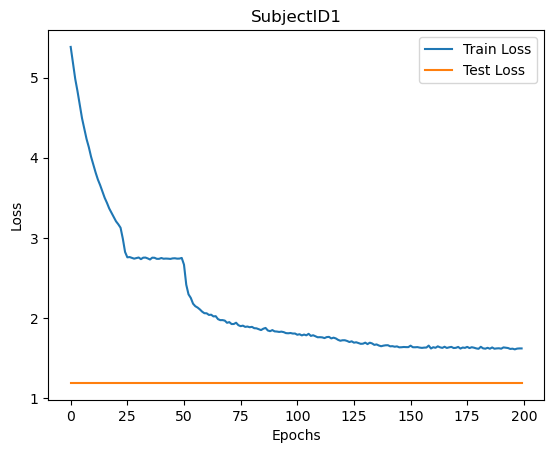

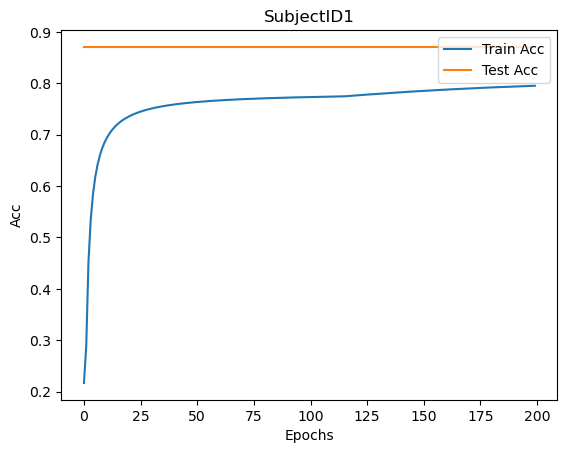


Subject 2
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2408 s/epoch | train loss 6.2059
| epoch   1 | 0.2416 s/epoch | train loss 5.7913
| epoch   2 | 0.2407 s/epoch | train loss 5.3850
| epoch   3 | 0.2423 s/epoch | train loss 4.4808
| epoch   4 | 0.2424 s/epoch | train loss 3.0099
| epoch   5 | 0.2428 s/epoch | train loss 2.8379
| epoch   6 | 0.2415 s/epoch | train loss 2.5956
| epoch   7 | 0.2416 s/epoch | train loss 2.2864
| epoch   8 | 0.2420 s/epoch | train loss 2.0108
| epoch   9 | 0.2410 s/epoch | train loss 1.9278
| epoch  10 | 0.2414 s/epoch | train loss 1.8989
| epoch  11 | 0.2413 s/epoch | train loss 1.8830
| epoch  12 | 0.2408 s/epoch | train loss 1.8732
| epoch  13 | 0.2407 s/epoch | train loss 1.8785
| epoch  14 | 0.2430 s/epoch | train loss 1.8490
| epoch  15 | 0.2420 s/epoch | train loss 1.8603
| epoch

| epoch 163 | 0.2405 s/epoch | train loss 1.5125
| epoch 164 | 0.2403 s/epoch | train loss 1.5148
| epoch 165 | 0.2411 s/epoch | train loss 1.5160
| epoch 166 | 0.2397 s/epoch | train loss 1.5133
| epoch 167 | 0.2404 s/epoch | train loss 1.5076
| epoch 168 | 0.2416 s/epoch | train loss 1.5053
| epoch 169 | 0.2422 s/epoch | train loss 1.5153
| epoch 170 | 0.2409 s/epoch | train loss 1.5031
| epoch 171 | 0.2419 s/epoch | train loss 1.5062
| epoch 172 | 0.2418 s/epoch | train loss 1.5105
| epoch 173 | 0.2404 s/epoch | train loss 1.5388
| epoch 174 | 0.2411 s/epoch | train loss 1.5223
| epoch 175 | 0.2410 s/epoch | train loss 1.5020
| epoch 176 | 0.2403 s/epoch | train loss 1.5118
| epoch 177 | 0.2413 s/epoch | train loss 1.5054
| epoch 178 | 0.2404 s/epoch | train loss 1.5243
| epoch 179 | 0.2401 s/epoch | train loss 1.5106
| epoch 180 | 0.2417 s/epoch | train loss 1.5182
| epoch 181 | 0.2425 s/epoch | train loss 1.5095
| epoch 182 | 0.2404 s/epoch | train loss 1.5093
| epoch 183 | 0.2407

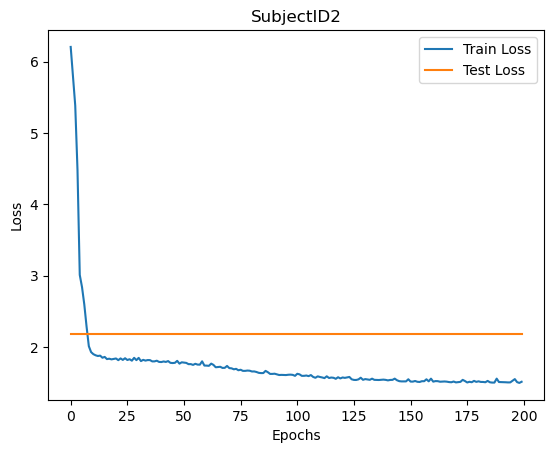

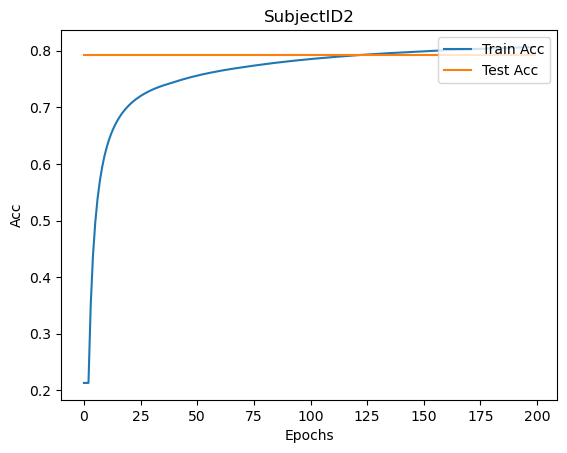


Subject 3
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2420 s/epoch | train loss 4.9138
| epoch   1 | 0.2419 s/epoch | train loss 4.7217
| epoch   2 | 0.2418 s/epoch | train loss 4.4942
| epoch   3 | 0.2411 s/epoch | train loss 4.1719
| epoch   4 | 0.2419 s/epoch | train loss 3.8330
| epoch   5 | 0.2402 s/epoch | train loss 3.5282
| epoch   6 | 0.2413 s/epoch | train loss 3.2670
| epoch   7 | 0.2409 s/epoch | train loss 3.0622
| epoch   8 | 0.2423 s/epoch | train loss 2.9055
| epoch   9 | 0.2421 s/epoch | train loss 2.8036
| epoch  10 | 0.2403 s/epoch | train loss 2.7390
| epoch  11 | 0.2406 s/epoch | train loss 2.6995
| epoch  12 | 0.2401 s/epoch | train loss 2.6812
| epoch  13 | 0.2408 s/epoch | train loss 2.6634
| epoch  14 | 0.2409 s/epoch | train loss 2.6723
| epoch  15 | 0.2412 s/epoch | train loss 2.6605
| epoch

| epoch 163 | 0.2410 s/epoch | train loss 2.6604
| epoch 164 | 0.2400 s/epoch | train loss 2.6548
| epoch 165 | 0.2419 s/epoch | train loss 2.6633
| epoch 166 | 0.2405 s/epoch | train loss 2.6562
| epoch 167 | 0.2415 s/epoch | train loss 2.6638
| epoch 168 | 0.2426 s/epoch | train loss 2.6650
| epoch 169 | 0.2421 s/epoch | train loss 2.6611
| epoch 170 | 0.2426 s/epoch | train loss 2.6593
| epoch 171 | 0.2416 s/epoch | train loss 2.6653
| epoch 172 | 0.2413 s/epoch | train loss 2.6677
| epoch 173 | 0.2412 s/epoch | train loss 2.6588
| epoch 174 | 0.2417 s/epoch | train loss 2.6684
| epoch 175 | 0.2429 s/epoch | train loss 2.6511
| epoch 176 | 0.2415 s/epoch | train loss 2.6546
| epoch 177 | 0.2415 s/epoch | train loss 2.6645
| epoch 178 | 0.2414 s/epoch | train loss 2.6599
| epoch 179 | 0.2409 s/epoch | train loss 2.6639
| epoch 180 | 0.2414 s/epoch | train loss 2.6634
| epoch 181 | 0.2413 s/epoch | train loss 2.6597
| epoch 182 | 0.2418 s/epoch | train loss 2.6576
| epoch 183 | 0.2418

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


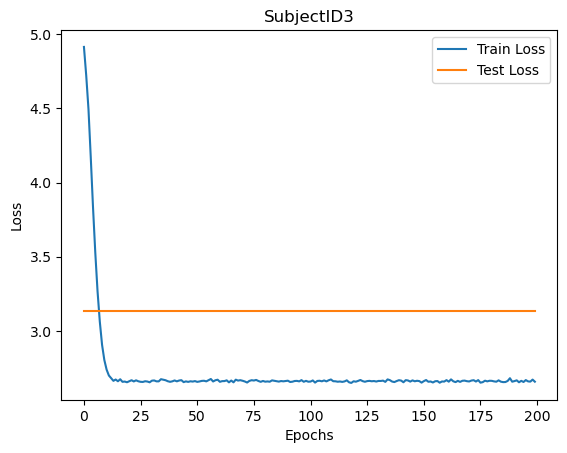

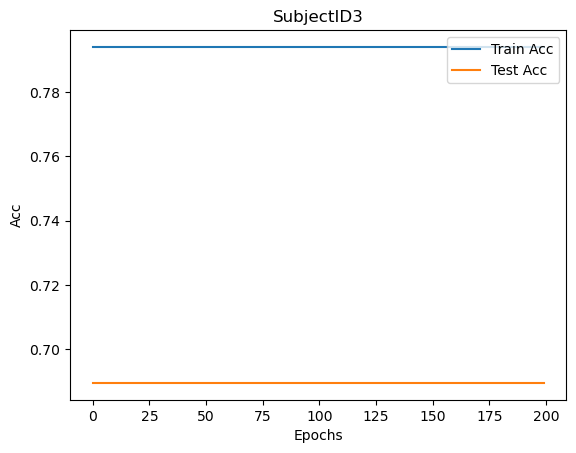


Subject 4
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2532 s/epoch | train loss 4.5561
| epoch   1 | 0.2526 s/epoch | train loss 4.2936
| epoch   2 | 0.2535 s/epoch | train loss 4.1290
| epoch   3 | 0.2525 s/epoch | train loss 4.0188
| epoch   4 | 0.2532 s/epoch | train loss 3.8970
| epoch   5 | 0.2527 s/epoch | train loss 3.7916
| epoch   6 | 0.2526 s/epoch | train loss 3.7070
| epoch   7 | 0.2522 s/epoch | train loss 3.6250
| epoch   8 | 0.2523 s/epoch | train loss 3.5335
| epoch   9 | 0.2531 s/epoch | train loss 3.4552
| epoch  10 | 0.2534 s/epoch | train loss 3.3938
| epoch  11 | 0.2523 s/epoch | train loss 3.3248
| epoch  12 | 0.2536 s/epoch | train loss 3.2756
| epoch  13 | 0.2532 s/epoch | train loss 3.2239
| epoch  14 | 0.2532 s/epoch | train loss 3.1749
| epoch  15 | 0.2536 s/epoch | train loss 3.1339
| epoch

| epoch 163 | 0.2534 s/epoch | train loss 2.7877
| epoch 164 | 0.2533 s/epoch | train loss 2.7961
| epoch 165 | 0.2527 s/epoch | train loss 2.7946
| epoch 166 | 0.2531 s/epoch | train loss 2.7883
| epoch 167 | 0.2526 s/epoch | train loss 2.7885
| epoch 168 | 0.2532 s/epoch | train loss 2.8021
| epoch 169 | 0.2532 s/epoch | train loss 2.7897
| epoch 170 | 0.2533 s/epoch | train loss 2.7943
| epoch 171 | 0.2521 s/epoch | train loss 2.7967
| epoch 172 | 0.2539 s/epoch | train loss 2.8051
| epoch 173 | 0.2527 s/epoch | train loss 2.7981
| epoch 174 | 0.2525 s/epoch | train loss 2.7906
| epoch 175 | 0.2516 s/epoch | train loss 2.7889
| epoch 176 | 0.2535 s/epoch | train loss 2.7982
| epoch 177 | 0.2537 s/epoch | train loss 2.7891
| epoch 178 | 0.2530 s/epoch | train loss 2.7862
| epoch 179 | 0.2526 s/epoch | train loss 2.7909
| epoch 180 | 0.2537 s/epoch | train loss 2.7897
| epoch 181 | 0.2527 s/epoch | train loss 2.7965
| epoch 182 | 0.2544 s/epoch | train loss 2.7923
| epoch 183 | 0.2540

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


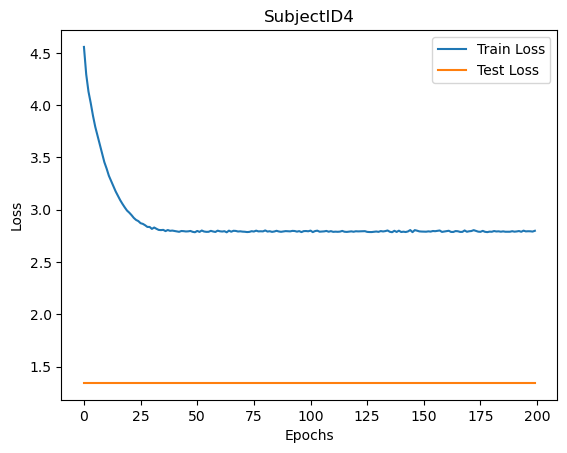

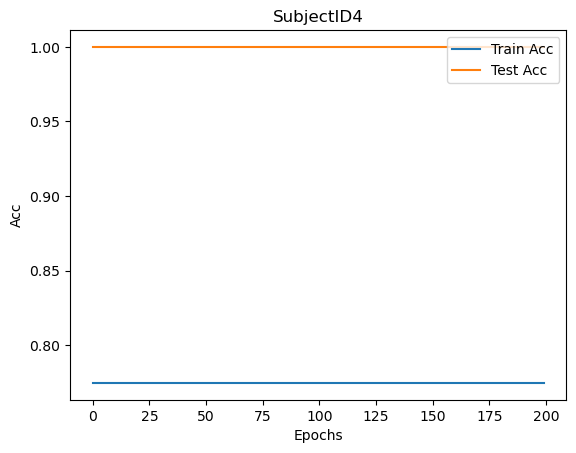


Subject 5
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2436 s/epoch | train loss 4.0080
| epoch   1 | 0.2420 s/epoch | train loss 3.1817
| epoch   2 | 0.2414 s/epoch | train loss 2.8765
| epoch   3 | 0.2428 s/epoch | train loss 2.6826
| epoch   4 | 0.2430 s/epoch | train loss 2.3945
| epoch   5 | 0.2419 s/epoch | train loss 2.0525
| epoch   6 | 0.2425 s/epoch | train loss 1.9045
| epoch   7 | 0.2424 s/epoch | train loss 1.8782
| epoch   8 | 0.2425 s/epoch | train loss 1.8650
| epoch   9 | 0.2439 s/epoch | train loss 1.8534
| epoch  10 | 0.2430 s/epoch | train loss 1.8414
| epoch  11 | 0.2401 s/epoch | train loss 1.8327
| epoch  12 | 0.2412 s/epoch | train loss 1.8211
| epoch  13 | 0.2412 s/epoch | train loss 1.8159
| epoch  14 | 0.2405 s/epoch | train loss 1.8085
| epoch  15 | 0.2425 s/epoch | train loss 1.8108
| epoch

| epoch 163 | 0.2418 s/epoch | train loss 1.4908
| epoch 164 | 0.2423 s/epoch | train loss 1.4913
| epoch 165 | 0.2431 s/epoch | train loss 1.4890
| epoch 166 | 0.2414 s/epoch | train loss 1.4925
| epoch 167 | 0.2431 s/epoch | train loss 1.4938
| epoch 168 | 0.2417 s/epoch | train loss 1.4880
| epoch 169 | 0.2419 s/epoch | train loss 1.4874
| epoch 170 | 0.2432 s/epoch | train loss 1.4899
| epoch 171 | 0.2427 s/epoch | train loss 1.4955
| epoch 172 | 0.2433 s/epoch | train loss 1.4852
| epoch 173 | 0.2402 s/epoch | train loss 1.4904
| epoch 174 | 0.2418 s/epoch | train loss 1.4923
| epoch 175 | 0.2417 s/epoch | train loss 1.4897
| epoch 176 | 0.2413 s/epoch | train loss 1.4822
| epoch 177 | 0.2421 s/epoch | train loss 1.4853
| epoch 178 | 0.2405 s/epoch | train loss 1.4903
| epoch 179 | 0.2421 s/epoch | train loss 1.4907
| epoch 180 | 0.2425 s/epoch | train loss 1.4899
| epoch 181 | 0.2419 s/epoch | train loss 1.4831
| epoch 182 | 0.2437 s/epoch | train loss 1.4847
| epoch 183 | 0.2444

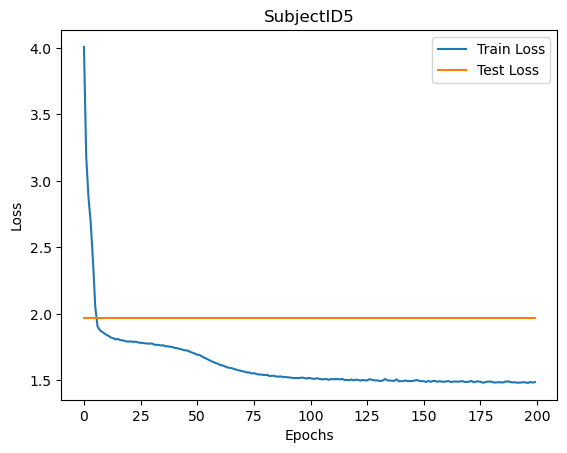

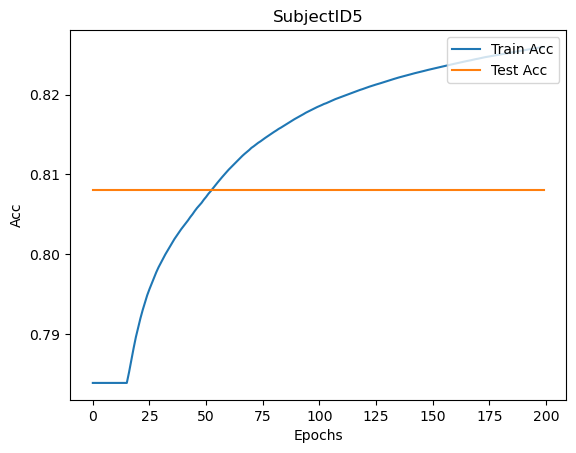


Subject 7
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2382 s/epoch | train loss 4.7194
| epoch   1 | 0.2369 s/epoch | train loss 3.6780
| epoch   2 | 0.2383 s/epoch | train loss 3.0482
| epoch   3 | 0.2376 s/epoch | train loss 2.9611
| epoch   4 | 0.2369 s/epoch | train loss 2.8777
| epoch   5 | 0.2375 s/epoch | train loss 2.7883
| epoch   6 | 0.2375 s/epoch | train loss 2.6831
| epoch   7 | 0.2365 s/epoch | train loss 2.5180
| epoch   8 | 0.2364 s/epoch | train loss 2.1865
| epoch   9 | 0.2370 s/epoch | train loss 1.9634
| epoch  10 | 0.2379 s/epoch | train loss 1.9023
| epoch  11 | 0.2376 s/epoch | train loss 1.8630
| epoch  12 | 0.2381 s/epoch | train loss 1.8369
| epoch  13 | 0.2376 s/epoch | train loss 1.8144
| epoch  14 | 0.2388 s/epoch | train loss 1.8019
| epoch  15 | 0.2369 s/epoch | train loss 1.7935
| epoch

| epoch 163 | 0.2377 s/epoch | train loss 1.4777
| epoch 164 | 0.2379 s/epoch | train loss 1.4799
| epoch 165 | 0.2377 s/epoch | train loss 1.4749
| epoch 166 | 0.2389 s/epoch | train loss 1.4772
| epoch 167 | 0.2370 s/epoch | train loss 1.4775
| epoch 168 | 0.2369 s/epoch | train loss 1.4745
| epoch 169 | 0.2363 s/epoch | train loss 1.4803
| epoch 170 | 0.2386 s/epoch | train loss 1.4816
| epoch 171 | 0.2361 s/epoch | train loss 1.4723
| epoch 172 | 0.2376 s/epoch | train loss 1.4759
| epoch 173 | 0.2362 s/epoch | train loss 1.4724
| epoch 174 | 0.2385 s/epoch | train loss 1.4763
| epoch 175 | 0.2373 s/epoch | train loss 1.4768
| epoch 176 | 0.2370 s/epoch | train loss 1.4768
| epoch 177 | 0.2374 s/epoch | train loss 1.4738
| epoch 178 | 0.2385 s/epoch | train loss 1.4781
| epoch 179 | 0.2372 s/epoch | train loss 1.4715
| epoch 180 | 0.2360 s/epoch | train loss 1.4756
| epoch 181 | 0.2401 s/epoch | train loss 1.4734
| epoch 182 | 0.2378 s/epoch | train loss 1.4714
| epoch 183 | 0.2380

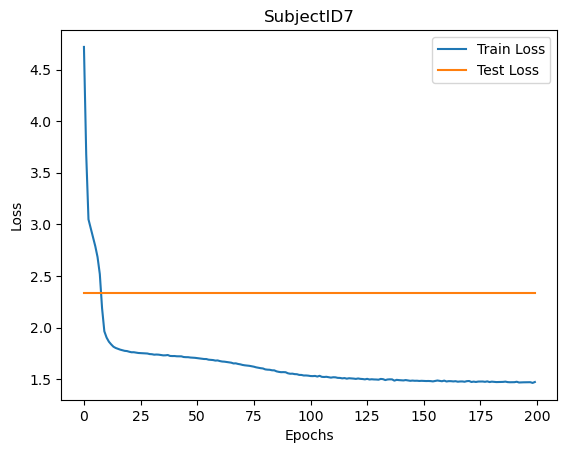

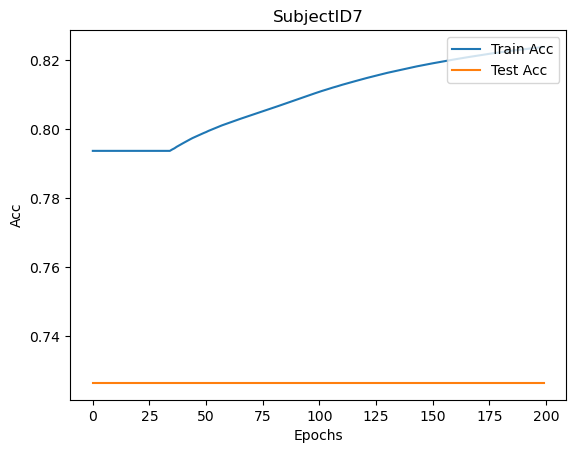


Subject 8
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2509 s/epoch | train loss 3.9206
| epoch   1 | 0.2479 s/epoch | train loss 3.1165
| epoch   2 | 0.2483 s/epoch | train loss 2.9565
| epoch   3 | 0.2486 s/epoch | train loss 2.8308
| epoch   4 | 0.2479 s/epoch | train loss 2.6525
| epoch   5 | 0.2492 s/epoch | train loss 2.3988
| epoch   6 | 0.2481 s/epoch | train loss 2.2328
| epoch   7 | 0.2490 s/epoch | train loss 2.0935
| epoch   8 | 0.2479 s/epoch | train loss 1.9879
| epoch   9 | 0.2464 s/epoch | train loss 1.9321
| epoch  10 | 0.2476 s/epoch | train loss 1.8796
| epoch  11 | 0.2488 s/epoch | train loss 1.8446
| epoch  12 | 0.2500 s/epoch | train loss 1.8211
| epoch  13 | 0.2497 s/epoch | train loss 1.8109
| epoch  14 | 0.2487 s/epoch | train loss 1.7957
| epoch  15 | 0.2481 s/epoch | train loss 1.7943
| epoch

| epoch 163 | 0.2785 s/epoch | train loss 1.5819
| epoch 164 | 0.2791 s/epoch | train loss 1.5796
| epoch 165 | 0.2765 s/epoch | train loss 1.5758
| epoch 166 | 0.2796 s/epoch | train loss 1.5778
| epoch 167 | 0.2786 s/epoch | train loss 1.5806
| epoch 168 | 0.2791 s/epoch | train loss 1.5785
| epoch 169 | 0.2815 s/epoch | train loss 1.5796
| epoch 170 | 0.2806 s/epoch | train loss 1.5753
| epoch 171 | 0.2788 s/epoch | train loss 1.5782
| epoch 172 | 0.2794 s/epoch | train loss 1.5729
| epoch 173 | 0.2784 s/epoch | train loss 1.5730
| epoch 174 | 0.2801 s/epoch | train loss 1.5758
| epoch 175 | 0.2796 s/epoch | train loss 1.5711
| epoch 176 | 0.2783 s/epoch | train loss 1.5759
| epoch 177 | 0.2779 s/epoch | train loss 1.5782
| epoch 178 | 0.2795 s/epoch | train loss 1.5729
| epoch 179 | 0.2802 s/epoch | train loss 1.5722
| epoch 180 | 0.2783 s/epoch | train loss 1.5735
| epoch 181 | 0.2785 s/epoch | train loss 1.5722
| epoch 182 | 0.2801 s/epoch | train loss 1.5719
| epoch 183 | 0.2792

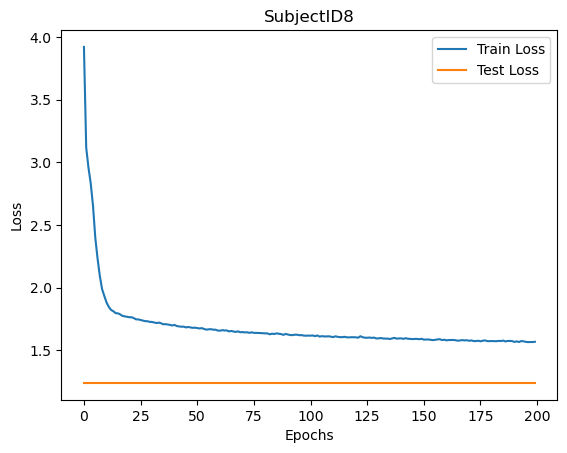

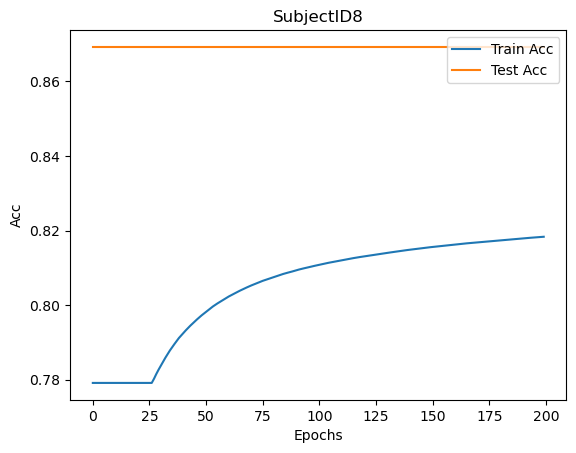


Subject 9
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2840 s/epoch | train loss 4.5546
| epoch   1 | 0.2852 s/epoch | train loss 4.3997
| epoch   2 | 0.2837 s/epoch | train loss 4.2574
| epoch   3 | 0.2844 s/epoch | train loss 4.1294
| epoch   4 | 0.2857 s/epoch | train loss 4.0105
| epoch   5 | 0.2827 s/epoch | train loss 3.9007
| epoch   6 | 0.2870 s/epoch | train loss 3.8002
| epoch   7 | 0.2839 s/epoch | train loss 3.7084
| epoch   8 | 0.2848 s/epoch | train loss 3.6242
| epoch   9 | 0.2838 s/epoch | train loss 3.5454
| epoch  10 | 0.2891 s/epoch | train loss 3.4736
| epoch  11 | 0.2866 s/epoch | train loss 3.4063
| epoch  12 | 0.2866 s/epoch | train loss 3.3450
| epoch  13 | 0.2894 s/epoch | train loss 3.2888
| epoch  14 | 0.2837 s/epoch | train loss 3.2362
| epoch  15 | 0.2831 s/epoch | train loss 3.1885
| epoch

| epoch 163 | 0.2579 s/epoch | train loss 1.5722
| epoch 164 | 0.2593 s/epoch | train loss 1.5713
| epoch 165 | 0.2597 s/epoch | train loss 1.5698
| epoch 166 | 0.2589 s/epoch | train loss 1.5695
| epoch 167 | 0.2544 s/epoch | train loss 1.5703
| epoch 168 | 0.2558 s/epoch | train loss 1.5702
| epoch 169 | 0.2539 s/epoch | train loss 1.5699
| epoch 170 | 0.2555 s/epoch | train loss 1.5670
| epoch 171 | 0.2562 s/epoch | train loss 1.5727
| epoch 172 | 0.2560 s/epoch | train loss 1.5660
| epoch 173 | 0.2614 s/epoch | train loss 1.5696
| epoch 174 | 0.2565 s/epoch | train loss 1.5723
| epoch 175 | 0.2612 s/epoch | train loss 1.5680
| epoch 176 | 0.2572 s/epoch | train loss 1.5691
| epoch 177 | 0.2588 s/epoch | train loss 1.5677
| epoch 178 | 0.2602 s/epoch | train loss 1.5642
| epoch 179 | 0.2555 s/epoch | train loss 1.5655
| epoch 180 | 0.2561 s/epoch | train loss 1.5660
| epoch 181 | 0.2603 s/epoch | train loss 1.5656
| epoch 182 | 0.2583 s/epoch | train loss 1.5668
| epoch 183 | 0.2550

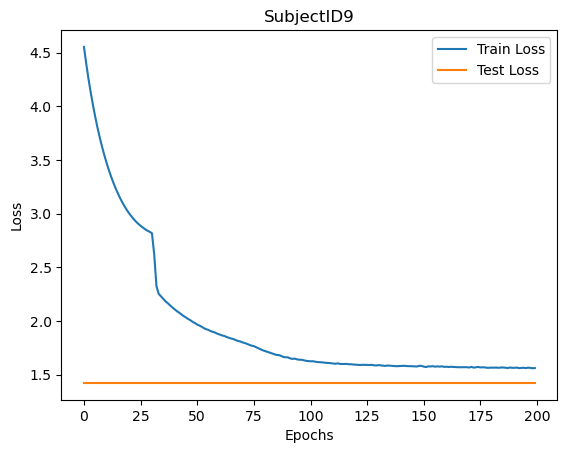

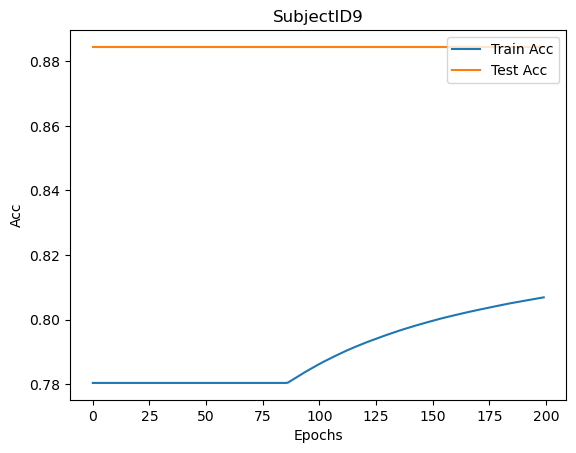


Subject 10
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2640 s/epoch | train loss 4.7235
| epoch   1 | 0.2632 s/epoch | train loss 3.7750
| epoch   2 | 0.2645 s/epoch | train loss 3.1601
| epoch   3 | 0.2621 s/epoch | train loss 3.0876
| epoch   4 | 0.2641 s/epoch | train loss 3.0264
| epoch   5 | 0.2640 s/epoch | train loss 2.9832
| epoch   6 | 0.2631 s/epoch | train loss 2.9277
| epoch   7 | 0.2635 s/epoch | train loss 2.8762
| epoch   8 | 0.2638 s/epoch | train loss 2.8080
| epoch   9 | 0.2679 s/epoch | train loss 2.7353
| epoch  10 | 0.2678 s/epoch | train loss 2.6318
| epoch  11 | 0.2687 s/epoch | train loss 2.4126
| epoch  12 | 0.2655 s/epoch | train loss 2.1377
| epoch  13 | 0.2665 s/epoch | train loss 1.9821
| epoch  14 | 0.2627 s/epoch | train loss 1.9219
| epoch  15 | 0.2625 s/epoch | train loss 1.9119
| epoc

| epoch 163 | 0.2598 s/epoch | train loss 1.7624
| epoch 164 | 0.2610 s/epoch | train loss 1.7537
| epoch 165 | 0.2632 s/epoch | train loss 1.7703
| epoch 166 | 0.2627 s/epoch | train loss 1.7591
| epoch 167 | 0.2693 s/epoch | train loss 1.7593
| epoch 168 | 0.2691 s/epoch | train loss 1.7501
| epoch 169 | 0.2694 s/epoch | train loss 1.7523
| epoch 170 | 0.2552 s/epoch | train loss 1.7519
| epoch 171 | 0.2564 s/epoch | train loss 1.7523
| epoch 172 | 0.2539 s/epoch | train loss 1.7465
| epoch 173 | 0.2553 s/epoch | train loss 1.7458
| epoch 174 | 0.2548 s/epoch | train loss 1.7436
| epoch 175 | 0.2628 s/epoch | train loss 1.7476
| epoch 176 | 0.2661 s/epoch | train loss 1.7517
| epoch 177 | 0.2630 s/epoch | train loss 1.7452
| epoch 178 | 0.2638 s/epoch | train loss 1.7454
| epoch 179 | 0.2645 s/epoch | train loss 1.7484
| epoch 180 | 0.2648 s/epoch | train loss 1.7446
| epoch 181 | 0.2643 s/epoch | train loss 1.7458
| epoch 182 | 0.2639 s/epoch | train loss 1.7434
| epoch 183 | 0.2638

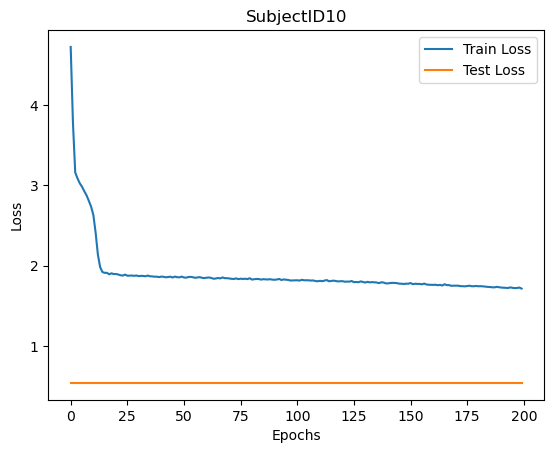

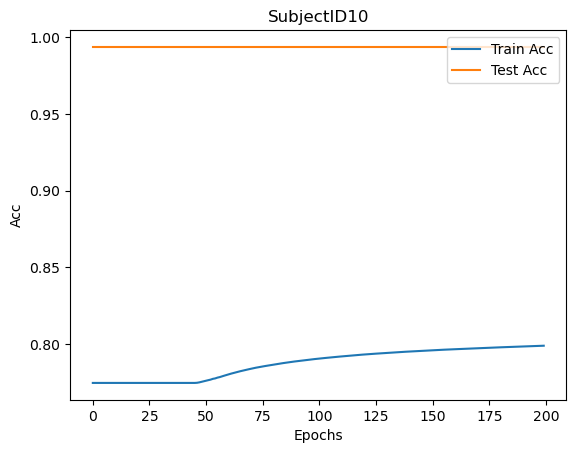


Subject 11
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2597 s/epoch | train loss 4.8470
| epoch   1 | 0.2601 s/epoch | train loss 4.6442
| epoch   2 | 0.2598 s/epoch | train loss 4.4747
| epoch   3 | 0.2606 s/epoch | train loss 4.3441
| epoch   4 | 0.2590 s/epoch | train loss 4.1947
| epoch   5 | 0.2611 s/epoch | train loss 4.0763
| epoch   6 | 0.2594 s/epoch | train loss 3.9647
| epoch   7 | 0.2579 s/epoch | train loss 3.8767
| epoch   8 | 0.2584 s/epoch | train loss 3.7674
| epoch   9 | 0.2593 s/epoch | train loss 3.6740
| epoch  10 | 0.2596 s/epoch | train loss 3.5954
| epoch  11 | 0.2604 s/epoch | train loss 3.5270
| epoch  12 | 0.2589 s/epoch | train loss 3.4562
| epoch  13 | 0.2589 s/epoch | train loss 3.3864
| epoch  14 | 0.2598 s/epoch | train loss 3.3267
| epoch  15 | 0.2598 s/epoch | train loss 3.2773
| epoc

| epoch 163 | 0.1911 s/epoch | train loss 2.7806
| epoch 164 | 0.1905 s/epoch | train loss 2.7724
| epoch 165 | 0.1902 s/epoch | train loss 2.7860
| epoch 166 | 0.1900 s/epoch | train loss 2.7908
| epoch 167 | 0.1901 s/epoch | train loss 2.7808
| epoch 168 | 0.1903 s/epoch | train loss 2.7842
| epoch 169 | 0.1899 s/epoch | train loss 2.7726
| epoch 170 | 0.1895 s/epoch | train loss 2.7965
| epoch 171 | 0.1908 s/epoch | train loss 2.7792
| epoch 172 | 0.1897 s/epoch | train loss 2.7710
| epoch 173 | 0.1907 s/epoch | train loss 2.7774
| epoch 174 | 0.1920 s/epoch | train loss 2.7756
| epoch 175 | 0.1913 s/epoch | train loss 2.7839
| epoch 176 | 0.1894 s/epoch | train loss 2.7799
| epoch 177 | 0.1909 s/epoch | train loss 2.7907
| epoch 178 | 0.1901 s/epoch | train loss 2.7816
| epoch 179 | 0.1916 s/epoch | train loss 2.7894
| epoch 180 | 0.1891 s/epoch | train loss 2.7773
| epoch 181 | 0.1902 s/epoch | train loss 2.7723
| epoch 182 | 0.1893 s/epoch | train loss 2.7866
| epoch 183 | 0.1910

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


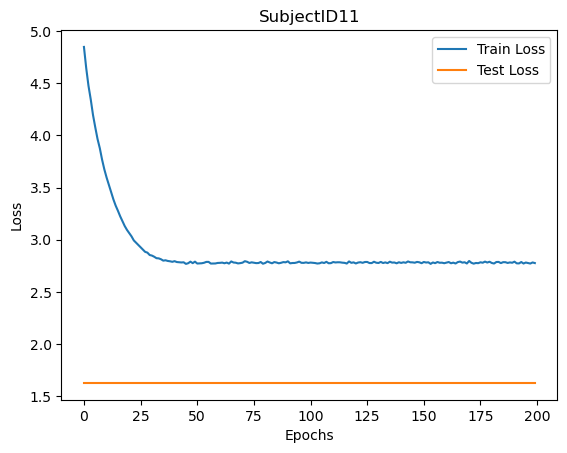

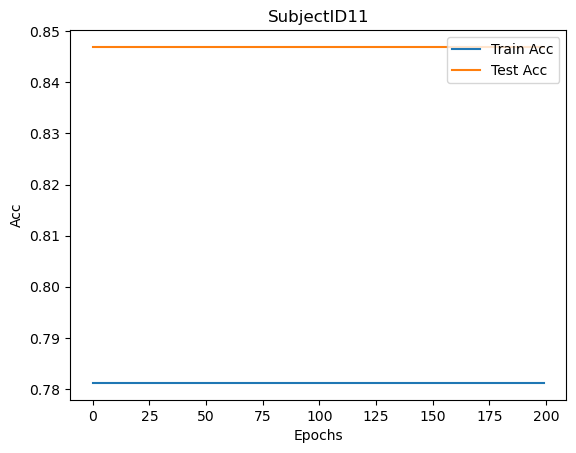


Subject 12
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1844 s/epoch | train loss 4.9604
| epoch   1 | 0.1802 s/epoch | train loss 4.6153
| epoch   2 | 0.1813 s/epoch | train loss 4.3153
| epoch   3 | 0.1814 s/epoch | train loss 4.0125
| epoch   4 | 0.1808 s/epoch | train loss 3.7136
| epoch   5 | 0.1816 s/epoch | train loss 3.4570
| epoch   6 | 0.1811 s/epoch | train loss 3.2309
| epoch   7 | 0.1808 s/epoch | train loss 3.0554
| epoch   8 | 0.1823 s/epoch | train loss 2.9194
| epoch   9 | 0.1814 s/epoch | train loss 2.8285
| epoch  10 | 0.1811 s/epoch | train loss 2.7680
| epoch  11 | 0.1816 s/epoch | train loss 2.7217
| epoch  12 | 0.1813 s/epoch | train loss 2.7079
| epoch  13 | 0.1805 s/epoch | train loss 2.6902
| epoch  14 | 0.1807 s/epoch | train loss 2.6811
| epoch  15 | 0.1820 s/epoch | train loss 2.6893
| epoc

| epoch 163 | 0.1827 s/epoch | train loss 2.6812
| epoch 164 | 0.1825 s/epoch | train loss 2.6934
| epoch 165 | 0.1818 s/epoch | train loss 2.6917
| epoch 166 | 0.1833 s/epoch | train loss 2.6870
| epoch 167 | 0.1813 s/epoch | train loss 2.6845
| epoch 168 | 0.1852 s/epoch | train loss 2.6916
| epoch 169 | 0.1919 s/epoch | train loss 2.6899
| epoch 170 | 0.1923 s/epoch | train loss 2.6805
| epoch 171 | 0.1885 s/epoch | train loss 2.6769
| epoch 172 | 0.1827 s/epoch | train loss 2.6854
| epoch 173 | 0.1855 s/epoch | train loss 2.6797
| epoch 174 | 0.1831 s/epoch | train loss 2.6825
| epoch 175 | 0.1844 s/epoch | train loss 2.6757
| epoch 176 | 0.1837 s/epoch | train loss 2.6838
| epoch 177 | 0.1851 s/epoch | train loss 2.6818
| epoch 178 | 0.1871 s/epoch | train loss 2.7094
| epoch 179 | 0.1833 s/epoch | train loss 2.6991
| epoch 180 | 0.1819 s/epoch | train loss 2.6971
| epoch 181 | 0.1873 s/epoch | train loss 2.6847
| epoch 182 | 0.1954 s/epoch | train loss 2.6868
| epoch 183 | 0.1879

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


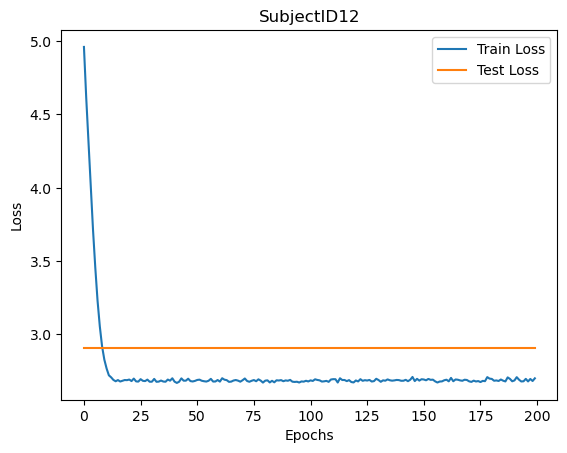

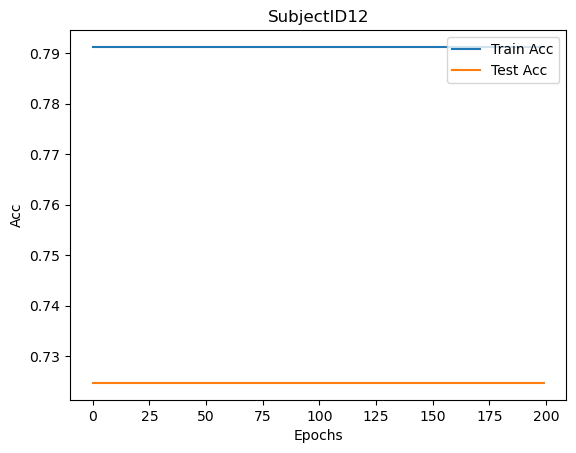


Subject 13
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1866 s/epoch | train loss 5.3676
| epoch   1 | 0.1906 s/epoch | train loss 5.1345
| epoch   2 | 0.1885 s/epoch | train loss 4.9683
| epoch   3 | 0.1896 s/epoch | train loss 4.7712
| epoch   4 | 0.1874 s/epoch | train loss 3.9828
| epoch   5 | 0.1887 s/epoch | train loss 2.8042
| epoch   6 | 0.1870 s/epoch | train loss 2.5922
| epoch   7 | 0.1883 s/epoch | train loss 2.2869
| epoch   8 | 0.1845 s/epoch | train loss 2.0718
| epoch   9 | 0.1824 s/epoch | train loss 1.9914
| epoch  10 | 0.1840 s/epoch | train loss 1.9408
| epoch  11 | 0.1817 s/epoch | train loss 1.9080
| epoch  12 | 0.1827 s/epoch | train loss 1.8701
| epoch  13 | 0.1820 s/epoch | train loss 1.8514
| epoch  14 | 0.1835 s/epoch | train loss 1.8305
| epoch  15 | 0.1848 s/epoch | train loss 1.8206
| epoc

| epoch 163 | 0.2863 s/epoch | train loss 1.4937
| epoch 164 | 0.2905 s/epoch | train loss 1.5003
| epoch 165 | 0.3134 s/epoch | train loss 1.4881
| epoch 166 | 0.3125 s/epoch | train loss 1.4961
| epoch 167 | 0.3156 s/epoch | train loss 1.4886
| epoch 168 | 0.3155 s/epoch | train loss 1.4986
| epoch 169 | 0.2921 s/epoch | train loss 1.5071
| epoch 170 | 0.3028 s/epoch | train loss 1.5027
| epoch 171 | 0.3226 s/epoch | train loss 1.4943
| epoch 172 | 0.3033 s/epoch | train loss 1.4879
| epoch 173 | 0.2930 s/epoch | train loss 1.4841
| epoch 174 | 0.2904 s/epoch | train loss 1.4851
| epoch 175 | 0.2998 s/epoch | train loss 1.4816
| epoch 176 | 0.3027 s/epoch | train loss 1.4995
| epoch 177 | 0.3004 s/epoch | train loss 1.4891
| epoch 178 | 0.2967 s/epoch | train loss 1.4906
| epoch 179 | 0.2967 s/epoch | train loss 1.4810
| epoch 180 | 0.2964 s/epoch | train loss 1.4880
| epoch 181 | 0.2980 s/epoch | train loss 1.4916
| epoch 182 | 0.2974 s/epoch | train loss 1.4896
| epoch 183 | 0.2967

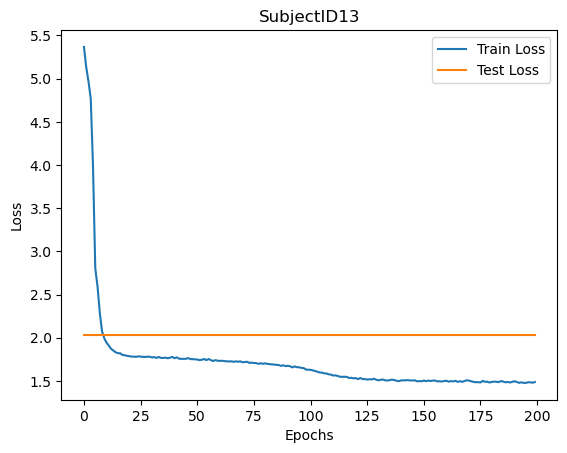

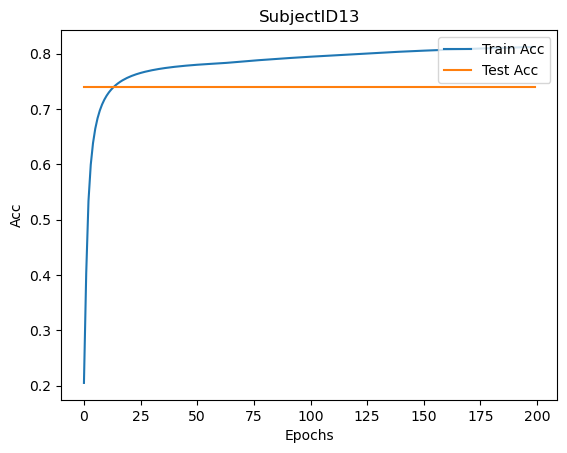


Subject 14
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2534 s/epoch | train loss 5.4054
| epoch   1 | 0.2515 s/epoch | train loss 3.8809
| epoch   2 | 0.2533 s/epoch | train loss 3.1263
| epoch   3 | 0.2537 s/epoch | train loss 2.9445
| epoch   4 | 0.2527 s/epoch | train loss 2.7427
| epoch   5 | 0.2530 s/epoch | train loss 2.5037
| epoch   6 | 0.2520 s/epoch | train loss 2.2824
| epoch   7 | 0.2548 s/epoch | train loss 2.1153
| epoch   8 | 0.2507 s/epoch | train loss 2.0393
| epoch   9 | 0.2478 s/epoch | train loss 2.0187
| epoch  10 | 0.2468 s/epoch | train loss 1.9969
| epoch  11 | 0.2460 s/epoch | train loss 1.9869
| epoch  12 | 0.2452 s/epoch | train loss 1.9460
| epoch  13 | 0.2471 s/epoch | train loss 1.9317
| epoch  14 | 0.2473 s/epoch | train loss 1.9263
| epoch  15 | 0.2448 s/epoch | train loss 1.9217
| epoc

| epoch 163 | 0.2521 s/epoch | train loss 1.5935
| epoch 164 | 0.2518 s/epoch | train loss 1.6290
| epoch 165 | 0.2504 s/epoch | train loss 1.6090
| epoch 166 | 0.2543 s/epoch | train loss 1.5967
| epoch 167 | 0.2536 s/epoch | train loss 1.6033
| epoch 168 | 0.2526 s/epoch | train loss 1.5960
| epoch 169 | 0.2513 s/epoch | train loss 1.5927
| epoch 170 | 0.2512 s/epoch | train loss 1.5934
| epoch 171 | 0.2531 s/epoch | train loss 1.5906
| epoch 172 | 0.2516 s/epoch | train loss 1.5850
| epoch 173 | 0.2529 s/epoch | train loss 1.5951
| epoch 174 | 0.2534 s/epoch | train loss 1.5910
| epoch 175 | 0.2516 s/epoch | train loss 1.5911
| epoch 176 | 0.2527 s/epoch | train loss 1.5923
| epoch 177 | 0.2530 s/epoch | train loss 1.5828
| epoch 178 | 0.2524 s/epoch | train loss 1.6113
| epoch 179 | 0.2535 s/epoch | train loss 1.5931
| epoch 180 | 0.2532 s/epoch | train loss 1.6099
| epoch 181 | 0.2533 s/epoch | train loss 1.5847
| epoch 182 | 0.2535 s/epoch | train loss 1.5946
| epoch 183 | 0.2533

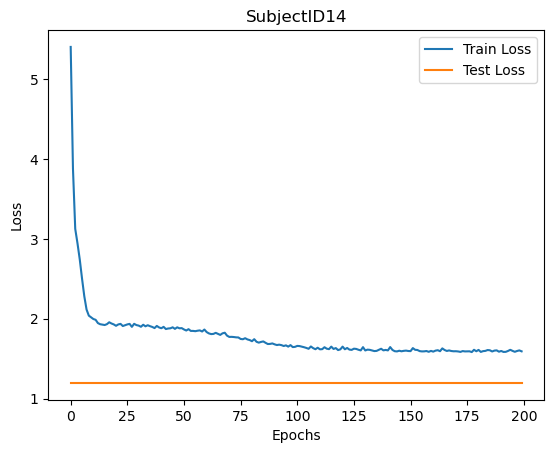

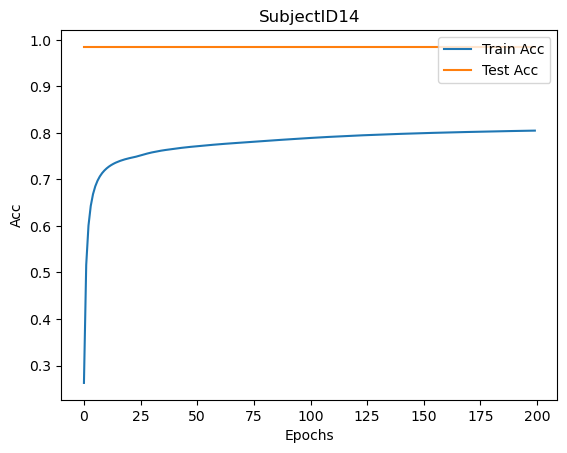


Subject 15
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2639 s/epoch | train loss 4.6950
| epoch   1 | 0.2628 s/epoch | train loss 4.3873
| epoch   2 | 0.2638 s/epoch | train loss 4.0756
| epoch   3 | 0.2642 s/epoch | train loss 3.7713
| epoch   4 | 0.2637 s/epoch | train loss 3.1785
| epoch   5 | 0.2613 s/epoch | train loss 2.7829
| epoch   6 | 0.2616 s/epoch | train loss 2.5956
| epoch   7 | 0.2629 s/epoch | train loss 2.3136
| epoch   8 | 0.2632 s/epoch | train loss 2.1615
| epoch   9 | 0.2621 s/epoch | train loss 2.0714
| epoch  10 | 0.2626 s/epoch | train loss 2.0046
| epoch  11 | 0.2632 s/epoch | train loss 1.9530
| epoch  12 | 0.2623 s/epoch | train loss 1.9181
| epoch  13 | 0.2625 s/epoch | train loss 1.9072
| epoch  14 | 0.2629 s/epoch | train loss 1.9030
| epoch  15 | 0.2640 s/epoch | train loss 1.8933
| epoc

| epoch 163 | 0.2634 s/epoch | train loss 1.5453
| epoch 164 | 0.2634 s/epoch | train loss 1.5422
| epoch 165 | 0.2636 s/epoch | train loss 1.5409
| epoch 166 | 0.2628 s/epoch | train loss 1.5443
| epoch 167 | 0.2627 s/epoch | train loss 1.5456
| epoch 168 | 0.2622 s/epoch | train loss 1.5443
| epoch 169 | 0.2632 s/epoch | train loss 1.5419
| epoch 170 | 0.2628 s/epoch | train loss 1.5417
| epoch 171 | 0.2641 s/epoch | train loss 1.5379
| epoch 172 | 0.2649 s/epoch | train loss 1.5398
| epoch 173 | 0.2630 s/epoch | train loss 1.5422
| epoch 174 | 0.2630 s/epoch | train loss 1.5396
| epoch 175 | 0.2634 s/epoch | train loss 1.5422
| epoch 176 | 0.2625 s/epoch | train loss 1.5410
| epoch 177 | 0.2625 s/epoch | train loss 1.5394
| epoch 178 | 0.2640 s/epoch | train loss 1.5408
| epoch 179 | 0.2639 s/epoch | train loss 1.5427
| epoch 180 | 0.2636 s/epoch | train loss 1.5405
| epoch 181 | 0.2632 s/epoch | train loss 1.5412
| epoch 182 | 0.2642 s/epoch | train loss 1.5396
| epoch 183 | 0.2638

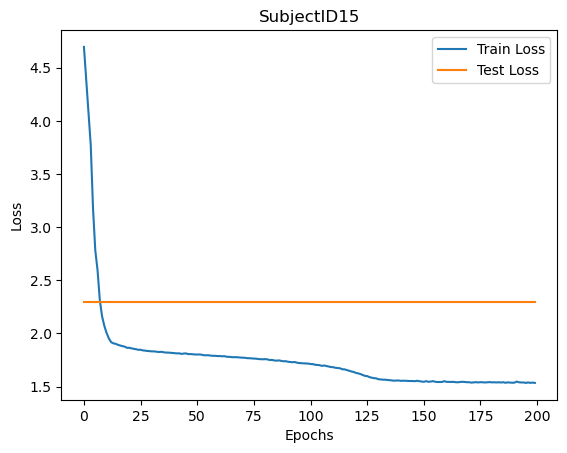

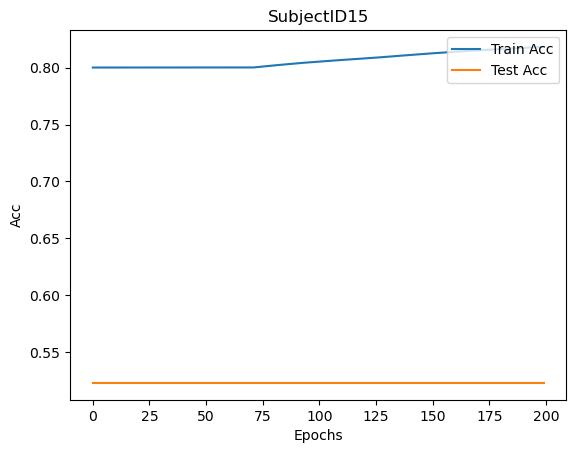

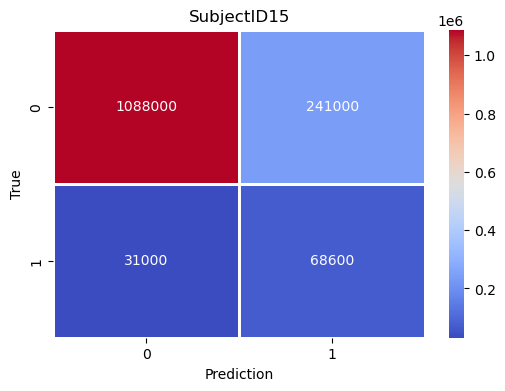

Distillation_Student(CNN_Small)_Acc: 0.8096038079238416
Distillation_Student(CNN_Small)_Rec: 0.6887550200803213
Distillation_Student(CNN_Small)_Pre: 0.22157622739018087
Distillation_Student(CNN_Small)_F1: 0.33528836754643204


<Figure size 640x480 with 0 Axes>

In [12]:
teacher_student_train_preds = []
teacher_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_Student(CNN_Small)_Acc:",teacher_Student_eval_table[0])
print("Distillation_Student(CNN_Small)_Rec:",teacher_Student_eval_table[1])
print("Distillation_Student(CNN_Small)_Pre:",teacher_Student_eval_table[2])
print("Distillation_Student(CNN_Small)_F1:",teacher_Student_eval_table[3])

In [13]:
# print("Teacher(RestNet50)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet50)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet50)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet50)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)



dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops:',flops_student, 'params', params_student)
print('\nflops_student: %.3f K, params_student: %.3f K' % (flops_student / 1000.0, params_student / 1000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops:',flops_teacher_student, 'params', params_teacher_student)
print('\nflops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_teacher_student / 1000.0, params_teacher_student / 1000.0))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


flops_teacher: 6823.395 M, params_teachar: 58.139 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
flops: 18176.0 params 58.0

flops_student: 18.176 K, params_student: 0.058 K
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv